In [32]:
%matplotlib inline
import sys

sys.path.append("..")

import gEconpy as ge
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

import pandas as pd

import arviz as az


print(f"Running gEconpy version {ge.__version__}")

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import VAR
from pandas_datareader.fred import FredReader
import os

config = {
    "figure.figsize": (14, 10),
    "figure.dpi": 144,
    "figure.facecolor": "white",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(config)

Running gEconpy version 1.2.1


In [33]:
indicators = [
    "NAEXKP01USQ652S",  # GDP
    "USAGFCFQDSMEI",  # Investment
    "USAPFCEQDSMEI",  # HH consumption
    "W068RCQ027SBEA",  # govt spending
    "HOANBS",  # non-farm hours worked
    "FEDFUNDS",  # real interest rate
    "COMPRNFB",  # average hourly wage
    "EXPGS",  # exports
    "IMPGS",  # imports
    "NCBEILQ027S",  # market value assets
    "TNWMVBSNNCB",  # replacement cost of capital
    "UNRATE",  # unemployment rate
    "CPIAUCSL",  # inflation
    "B075RC1Q027SBEA",  # tax receipts
]


if not os.path.isfile("us_fred_data.csv"):
    data = FredReader(symbols=indicators, start="1900", end=None).read()
    data.to_csv("us_fred_data.csv")
else:
    data = pd.read_csv(
        "us_fred_data.csv",
        index_col=0,
        parse_dates=["DATE"],
    )

In [34]:
df = data.resample("QS").last()
df = df.rename(columns=dict(zip(indicators, ["Y", "I", "C", "G", "L", "r", "w", "X", "M", "marval", "rcc", "u", "pi", "tax"])))
df.index.name = "Time"

# Regular at least 3 observed series
df.dropna(thresh=3, inplace=True)

df['Q'] = df['marval']/df['rcc']
df = df.drop(['marval', 'rcc'], axis=1)

df['XM'] = df['X'] + df['M']
df = df.drop(['X', 'M'], axis=1)

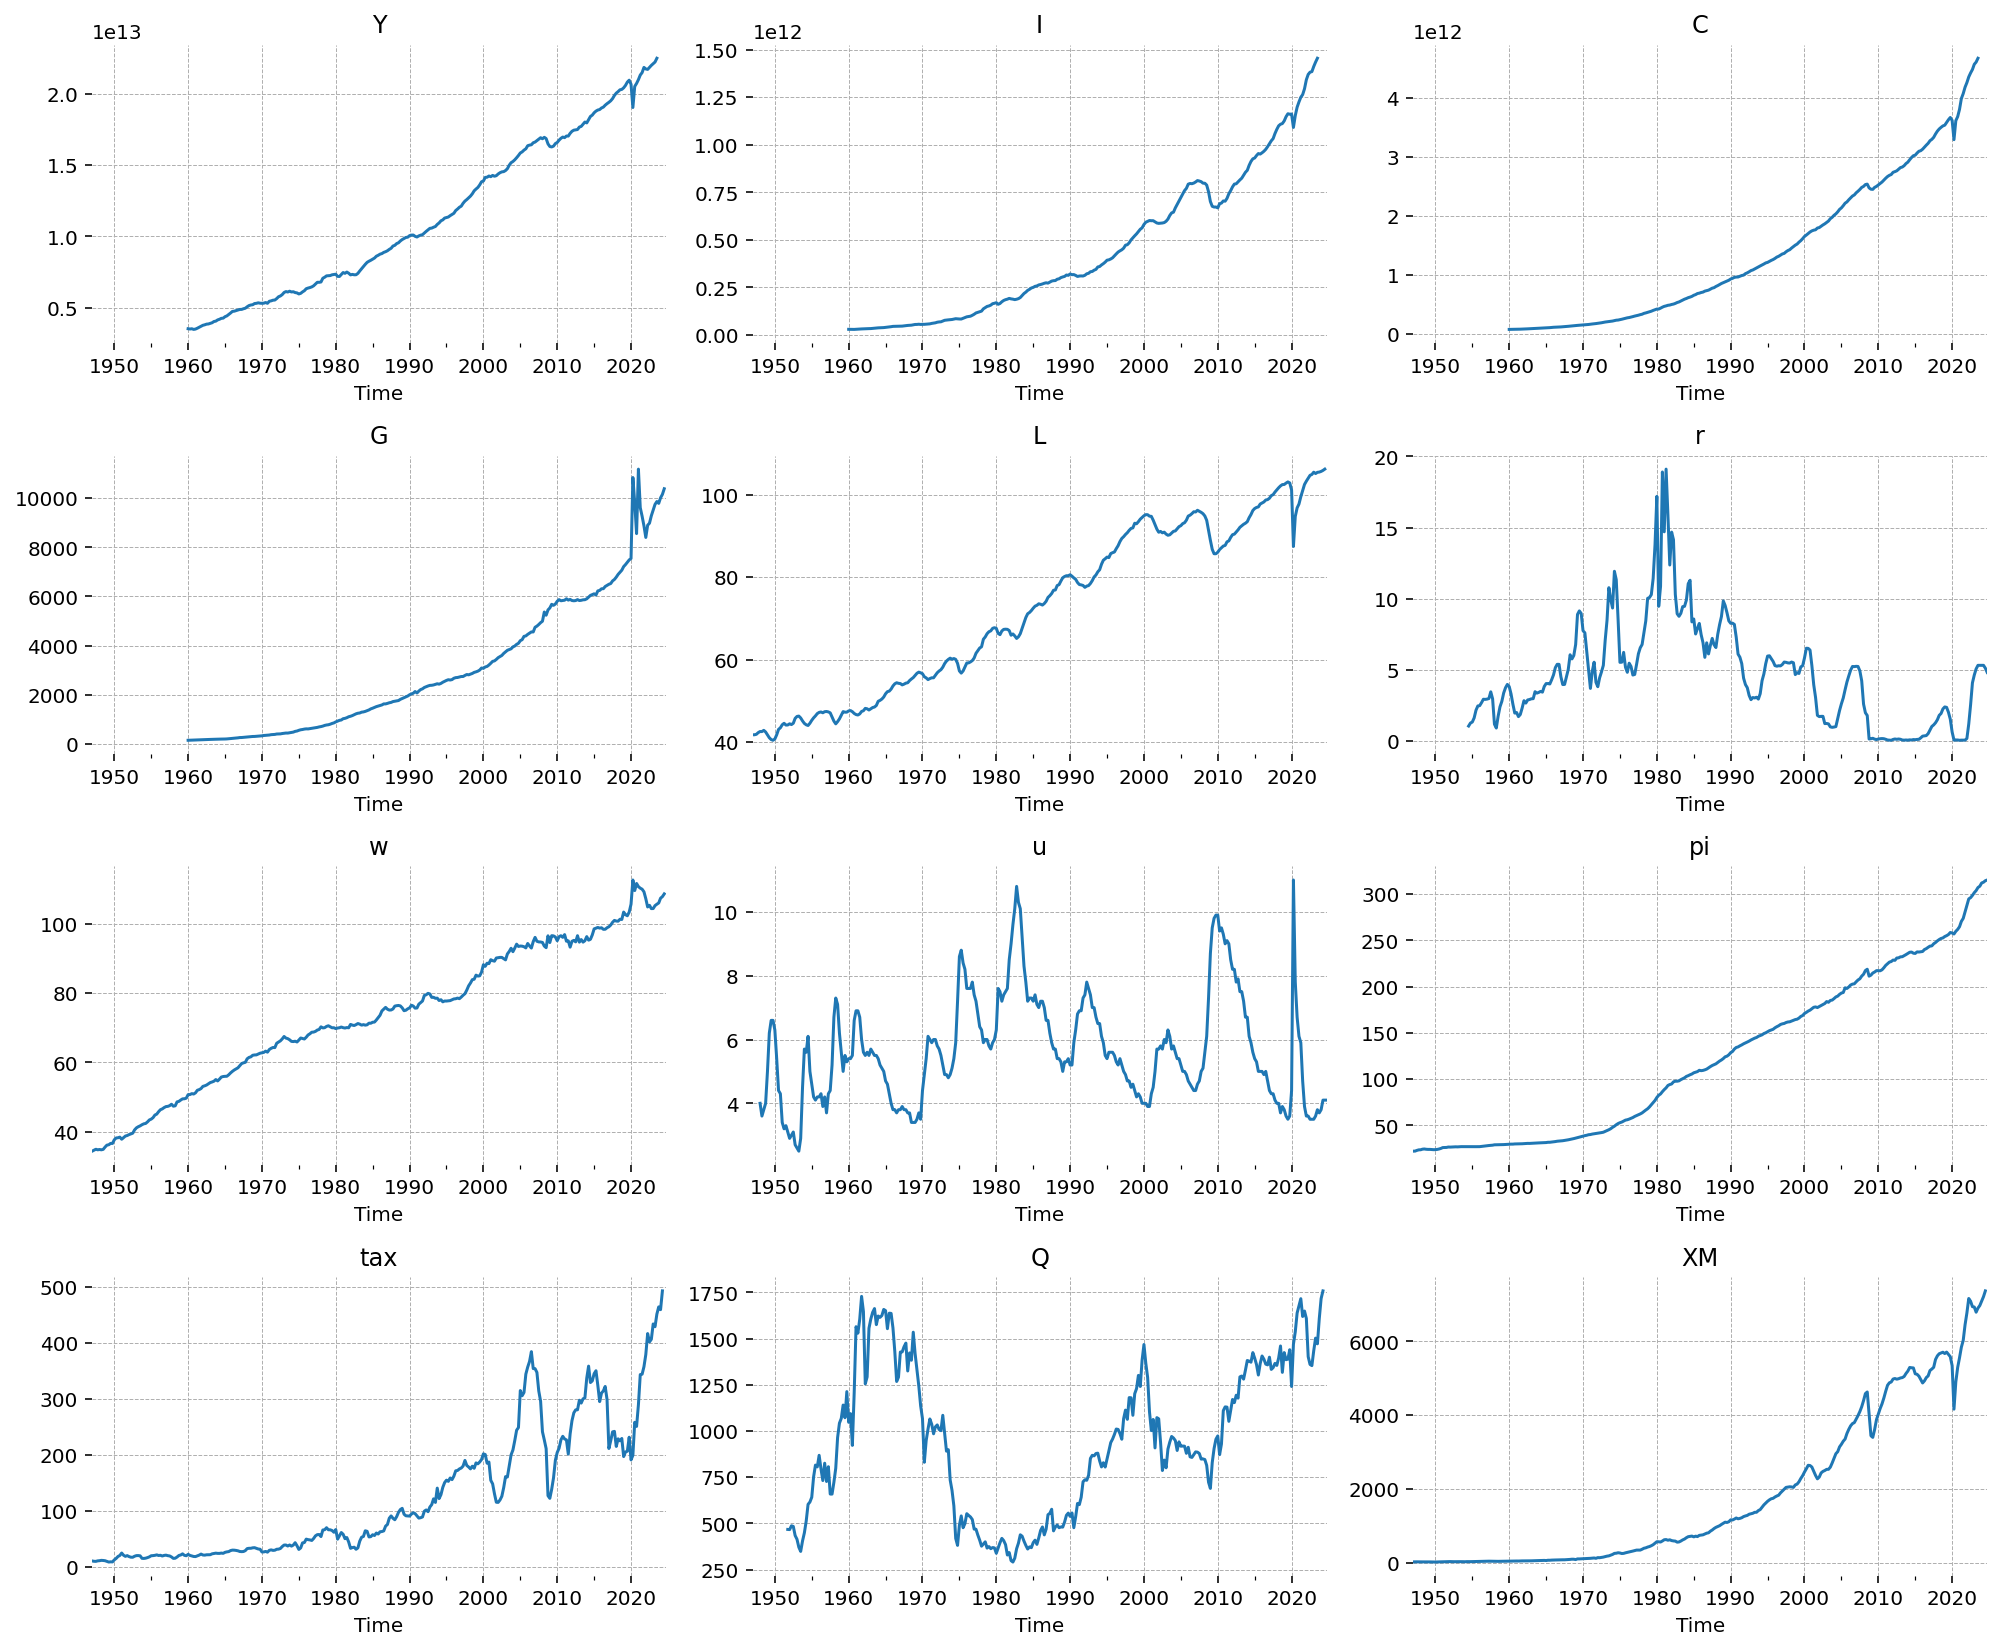

In [43]:
def plot_df(df):
    fig = plt.figure(figsize=(14, 14), dpi=144)
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=df.shape[1])

    for loc, var in zip(plot_locs, df):
        axis = fig.add_subplot(gs[loc])
        df[var].plot(ax=axis)
        axis.set_title(var)

    fig.tight_layout()
    plt.show()


plot_df(df)

In [44]:
X = np.c_[np.ones(df.shape[0]), np.arange(df.shape[0]), np.arange(df.shape[0]) ** 2]
df_detrend = df.copy().apply(np.log)
df_detrend["r"] = df["r"].mul(1e-2).add(1)

for col in df:
    y = df_detrend[col]
    not_na = y.notna().values
    X_valid = X[not_na, :]
    beta = np.linalg.inv(X_valid.T @ X_valid) @ X_valid.T @ y.dropna()
    trend = X_valid @ beta
    resid = y.dropna() - trend
    df_detrend.loc[not_na, col] = resid

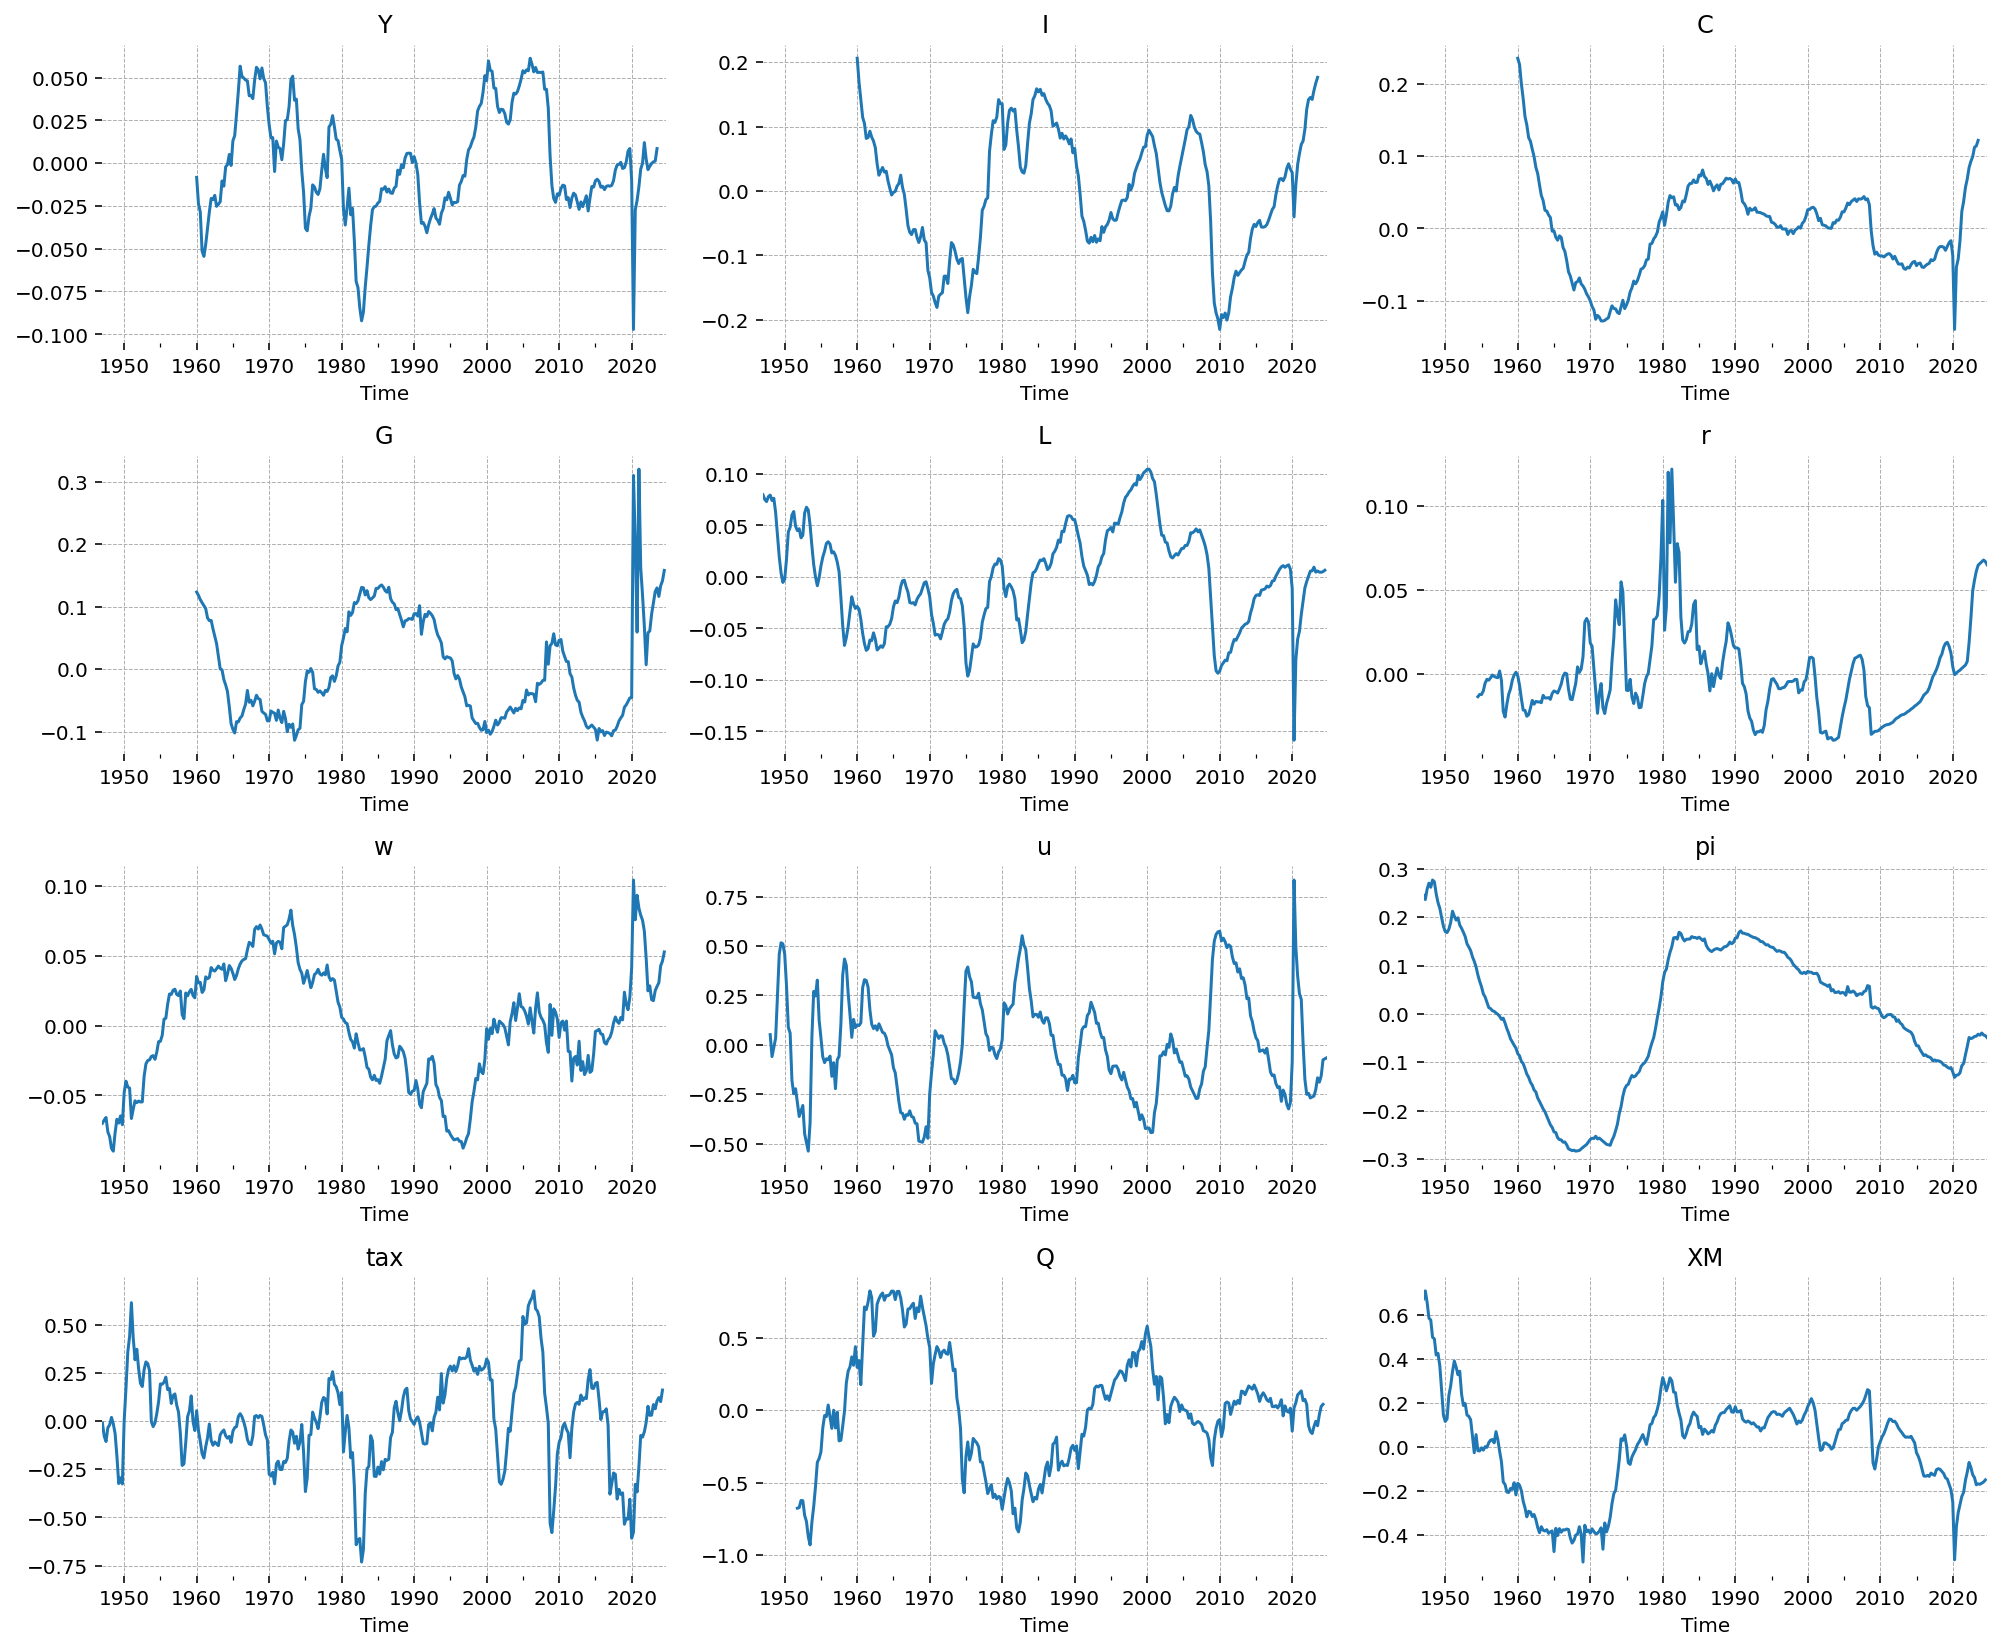

In [45]:
plot_df(df_detrend)

In [46]:
df_detrend = df_detrend.dropna()
df_detrend = df_detrend.diff().dropna()

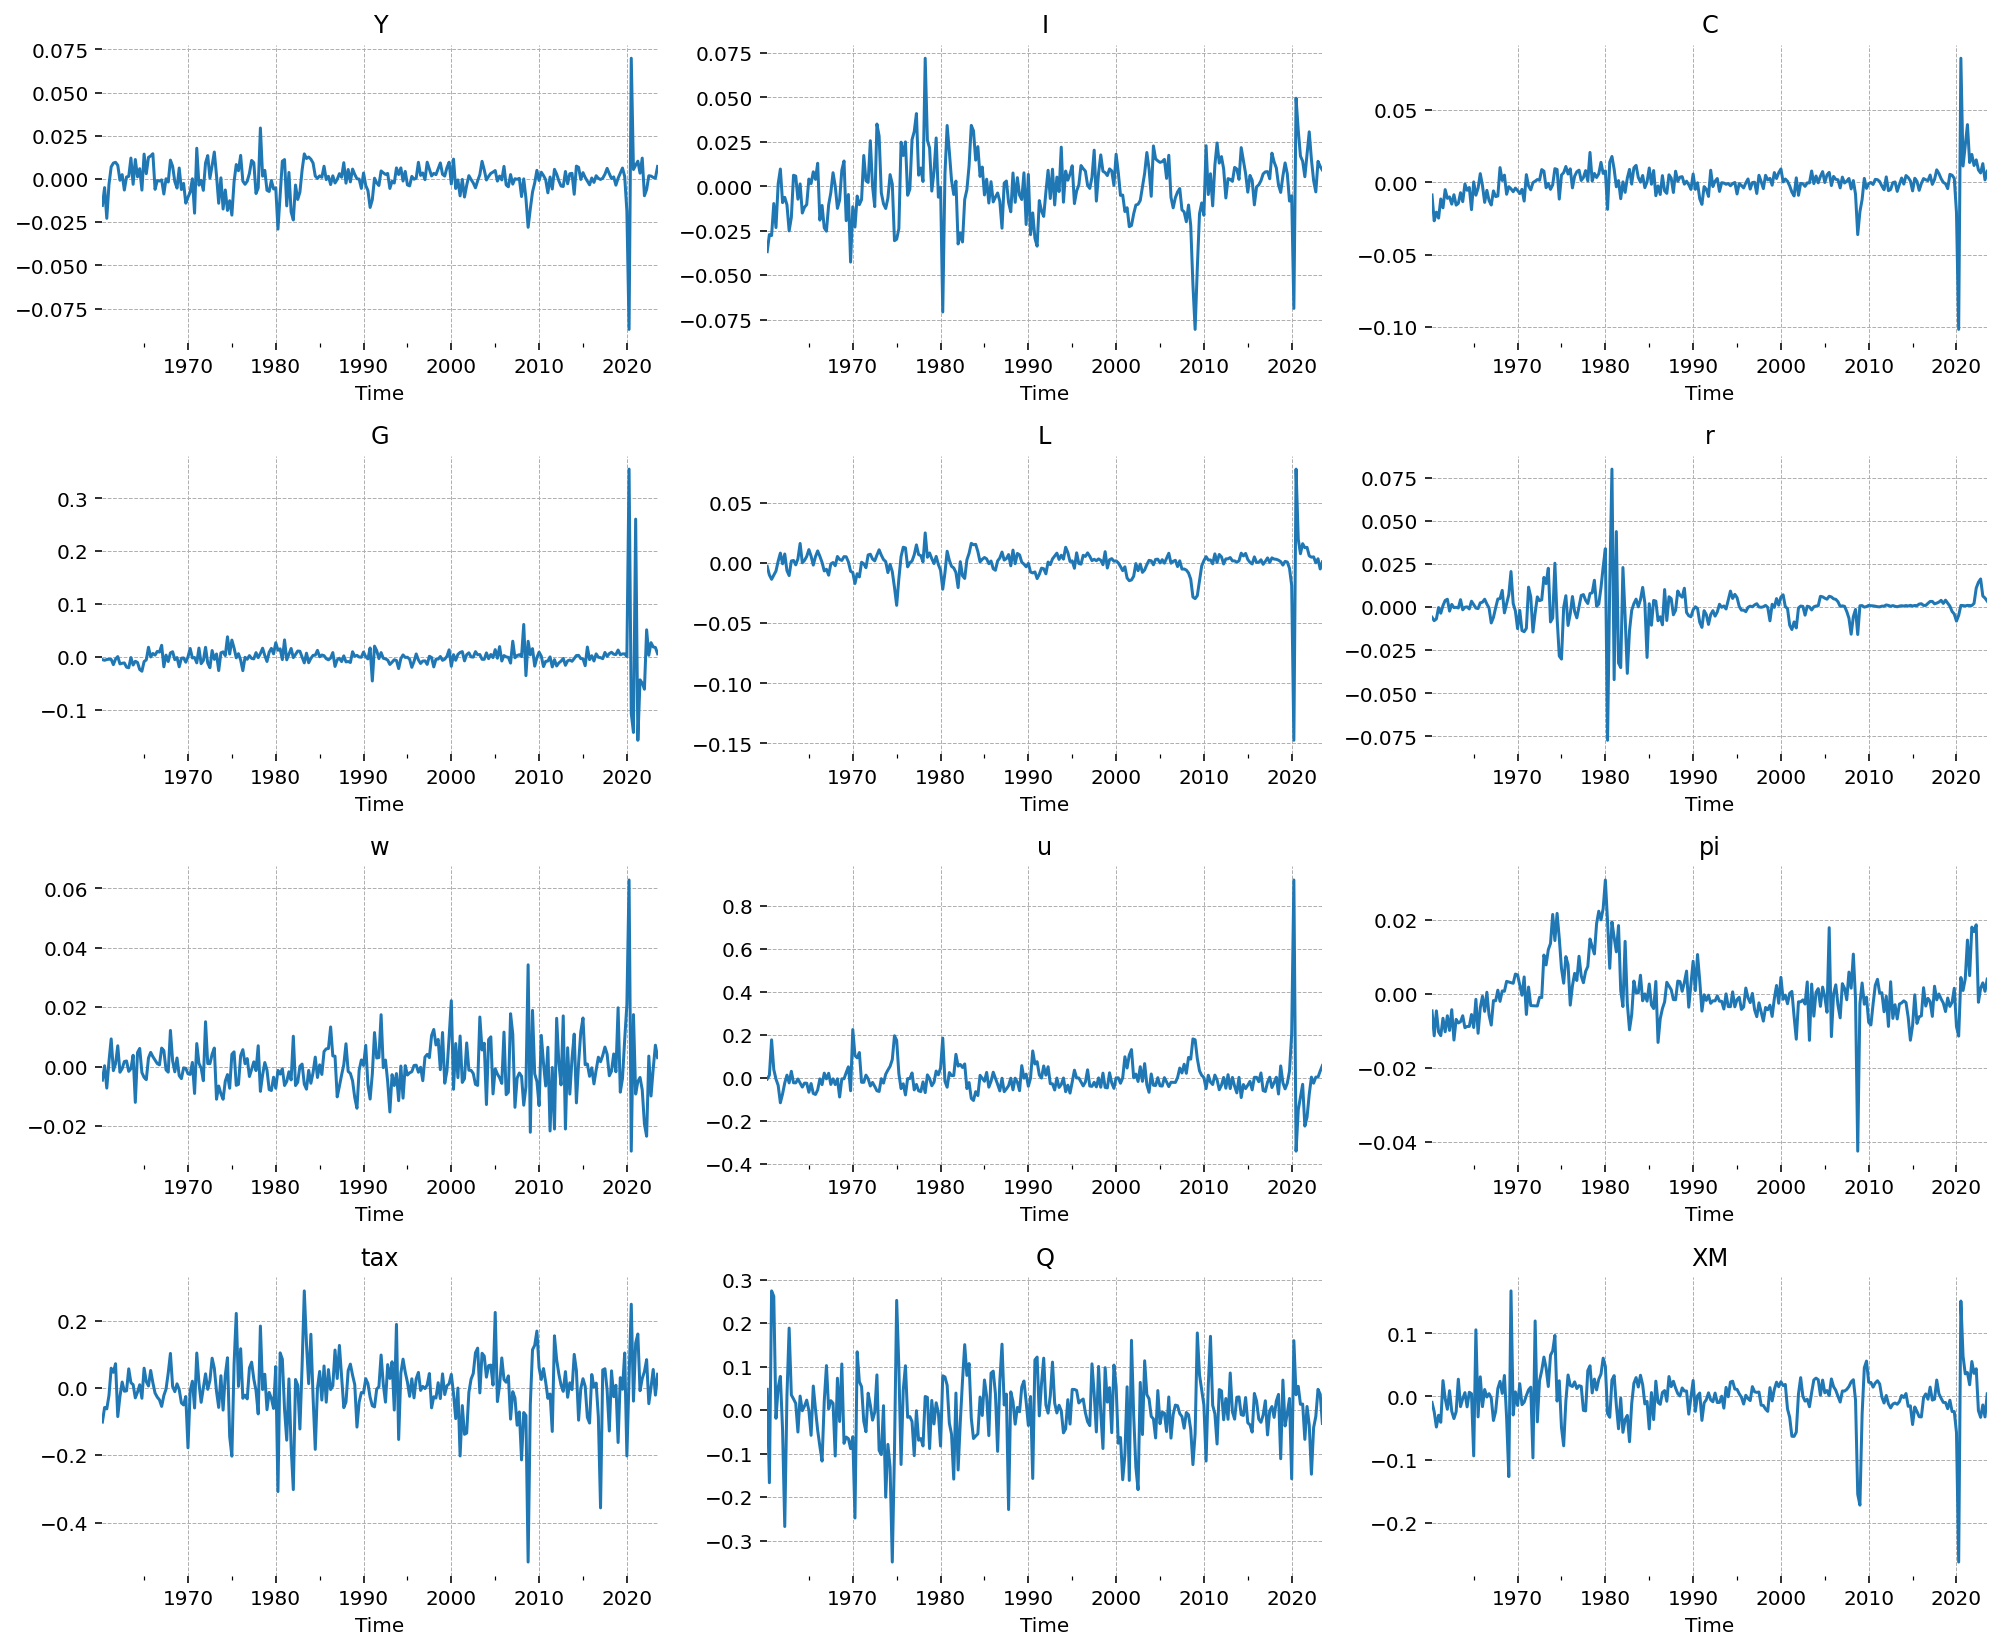

In [47]:
plot_df(df_detrend)

In [49]:
df_detrend

,Y,I,C,G,L,r,w,u,pi,tax,Q,XM
Time,,,,,,,,,,,,
1960-04-01,-0.015294,-0.036730,-0.008692,-0.005317,-0.002652,-0.005818,-0.004551,-0.004315,-0.004616,-0.101629,0.047938,-0.009480
1960-07-01,-0.004988,-0.027118,-0.026607,-0.006644,-0.009900,-0.007812,0.000301,0.014071,-0.011375,-0.058389,-0.166958,-0.024226
1960-10-01,-0.022769,-0.027661,-0.020583,-0.005154,-0.013472,-0.006805,-0.007228,0.178080,-0.004625,-0.062474,0.274542,-0.048410
1961-01-01,-0.003106,-0.009655,-0.024718,-0.004563,-0.010048,-0.000199,0.001841,0.040247,-0.010332,-0.022461,0.261960,-0.029750
1961-04-01,0.007024,-0.023181,-0.011477,-0.004912,-0.006565,-0.003492,0.009344,-0.004168,-0.011320,0.058358,-0.018750,-0.040888
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,0.001900,0.003270,0.008694,0.002915,0.005187,0.014494,0.003565,-0.023350,-0.002291,-0.047047,-0.040072,-0.022599
2022-10-01,0.001690,-0.003112,0.006522,0.026727,0.000236,0.016400,-0.009893,0.004857,0.001482,0.001210,-0.014395,-0.033059
2023-01-01,0.000925,0.014089,0.013005,0.018689,0.003604,0.006507,-0.000702,0.004894,0.002961,0.054637,0.047985,-0.013416


In [63]:
model = VAR(df_detrend)

In [67]:
lag_order_results = model.select_order(maxlags=16)

# Display the selected lags based on AIC, BIC, HQIC, FPE
print(lag_order_results.summary())

# Choose the lag with the lowest AIC (or BIC) and fit the model
optimal_lag = lag_order_results.aic  # Replace 'aic' with 'bic' for BIC, or other criteria

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -97.56     -97.38*   4.281e-43      -97.49
1       -99.09      -96.82   9.237e-44     -98.17*
2       -99.40      -95.03   6.820e-44      -97.64
3       -99.83      -93.35  4.566e-44*      -97.22
4       -99.49      -90.91   6.659e-44      -96.03
5       -99.57      -88.89   6.612e-44      -95.26
6       -99.38      -86.60   8.804e-44      -94.23
7       -99.41      -84.53   9.922e-44      -93.42
8       -99.37      -82.39   1.274e-43      -92.53
9       -99.17      -80.09   2.057e-43      -91.48
10      -99.31      -78.12   2.599e-43      -90.77
11      -99.33      -76.05   4.105e-43      -89.95
12      -99.59      -74.21   5.943e-43      -89.36
13      -100.2      -72.73   7.244e-43      -89.13
14      -101.4      -71.86   6.149e-43      -89.53
15      -102.8      -71.16   6.345e-43      -90.08
16     -105.1*      -71.29   4.

In [68]:
results = model.fit(maxlags=lag_order_results.hqic)  # Choose optimal lag length based on criteria (AIC, BIC, etc.)

# Summary of model
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Nov, 2024
Time:                     22:51:56
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -96.9300
Nobs:                     253.000    HQIC:                  -98.2321
Log likelihood:           8385.35    FPE:                9.08055e-44
AIC:                     -99.1087    Det(Omega_mle):     4.97713e-44
--------------------------------------------------------------------
Results for equation Y
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000203         0.000581            0.350           0.726
L1.Y          -0.186423         0.118509           -1.573           0.116
L1.I           0.129359         0.050317            2.571           0.010
L1.C           0.0

In [69]:
irf = results.irf(40)

- Cutting government spending
- Increased tariffs
- Increasing stock market evaluations
- Mass deportation
- Ending Fed independence (departure from Taylor rule)

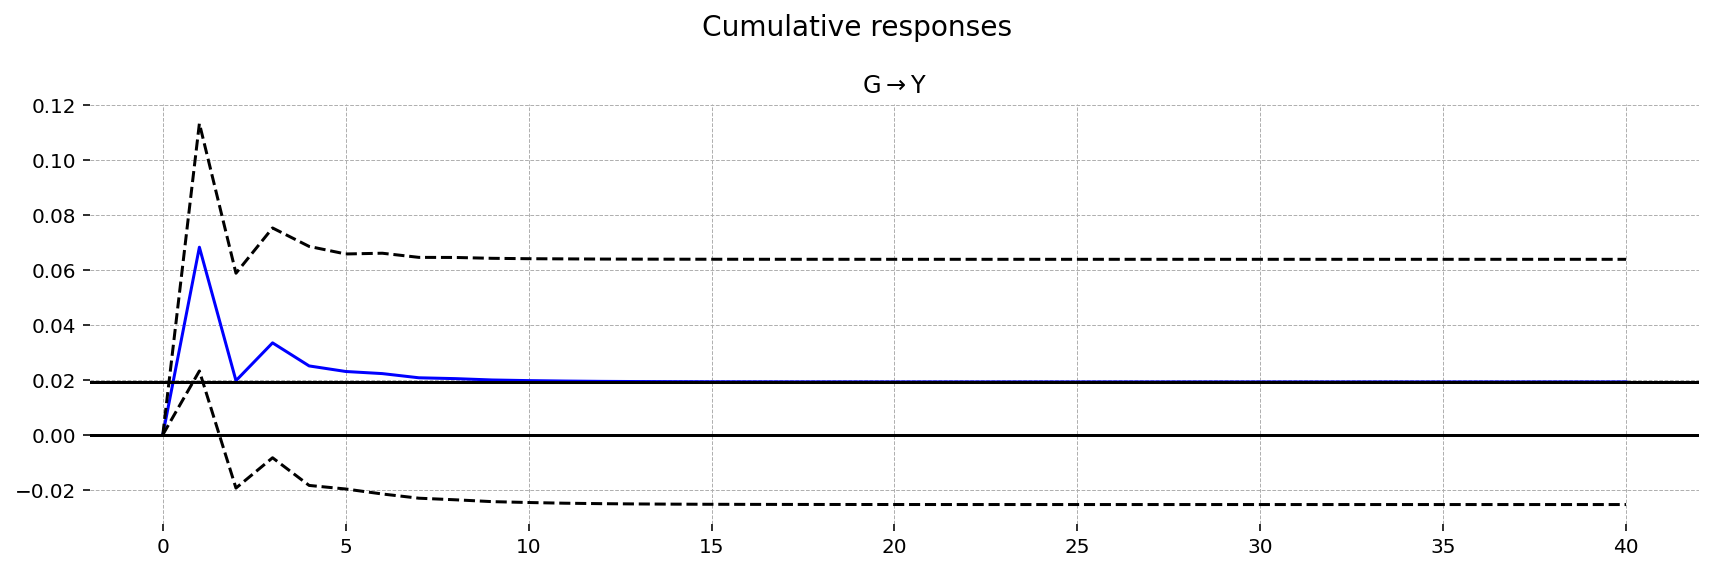

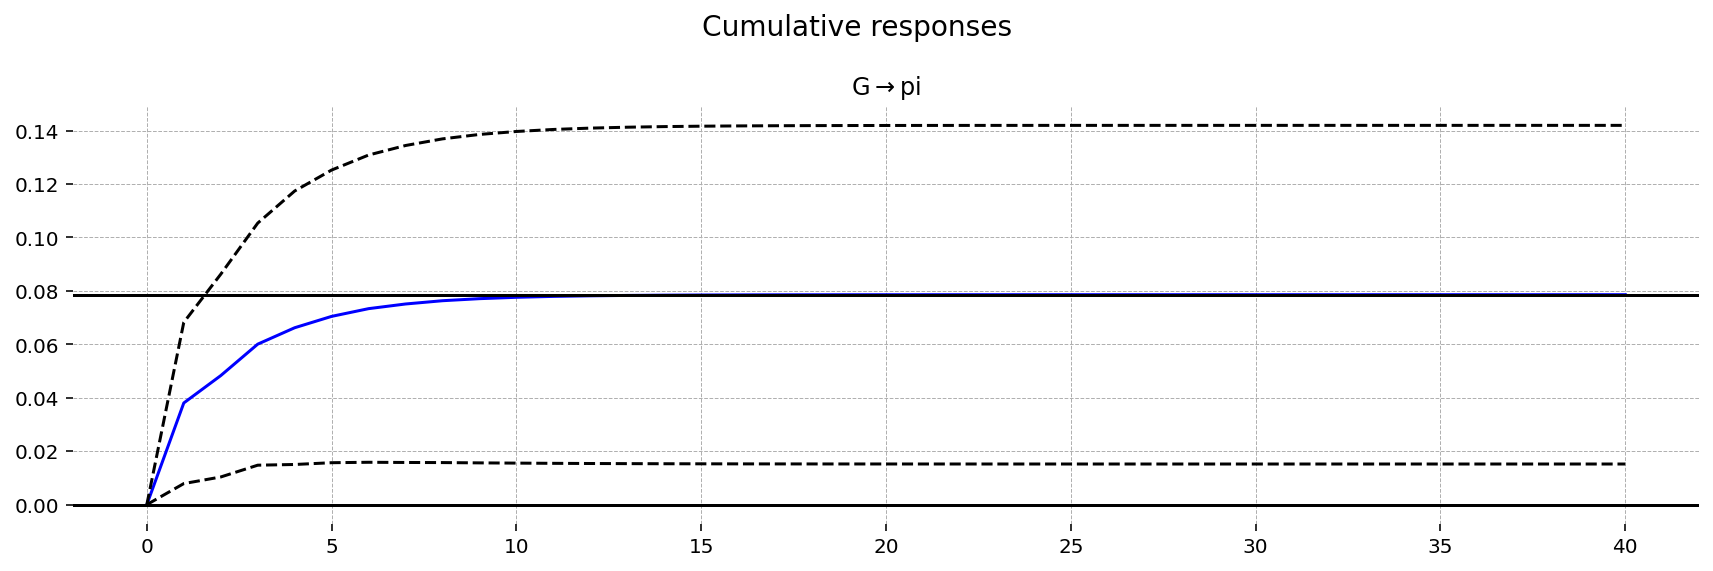

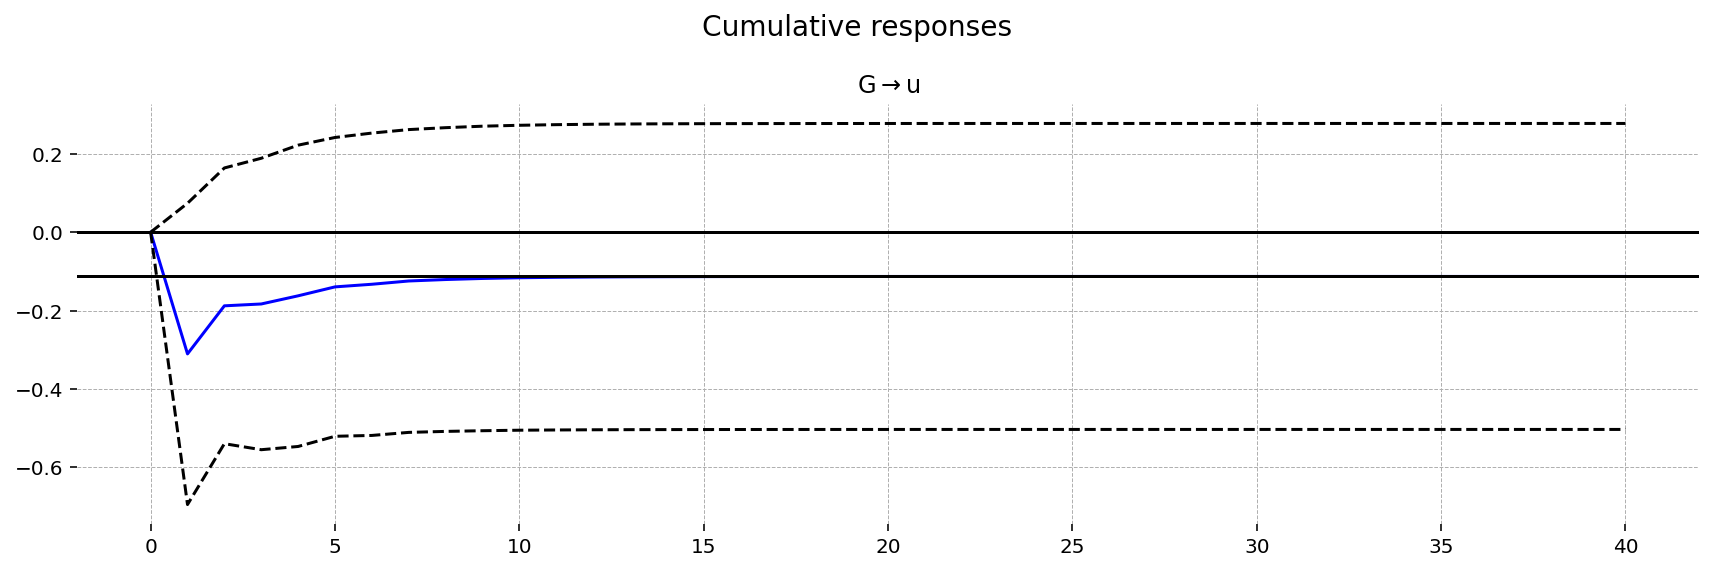

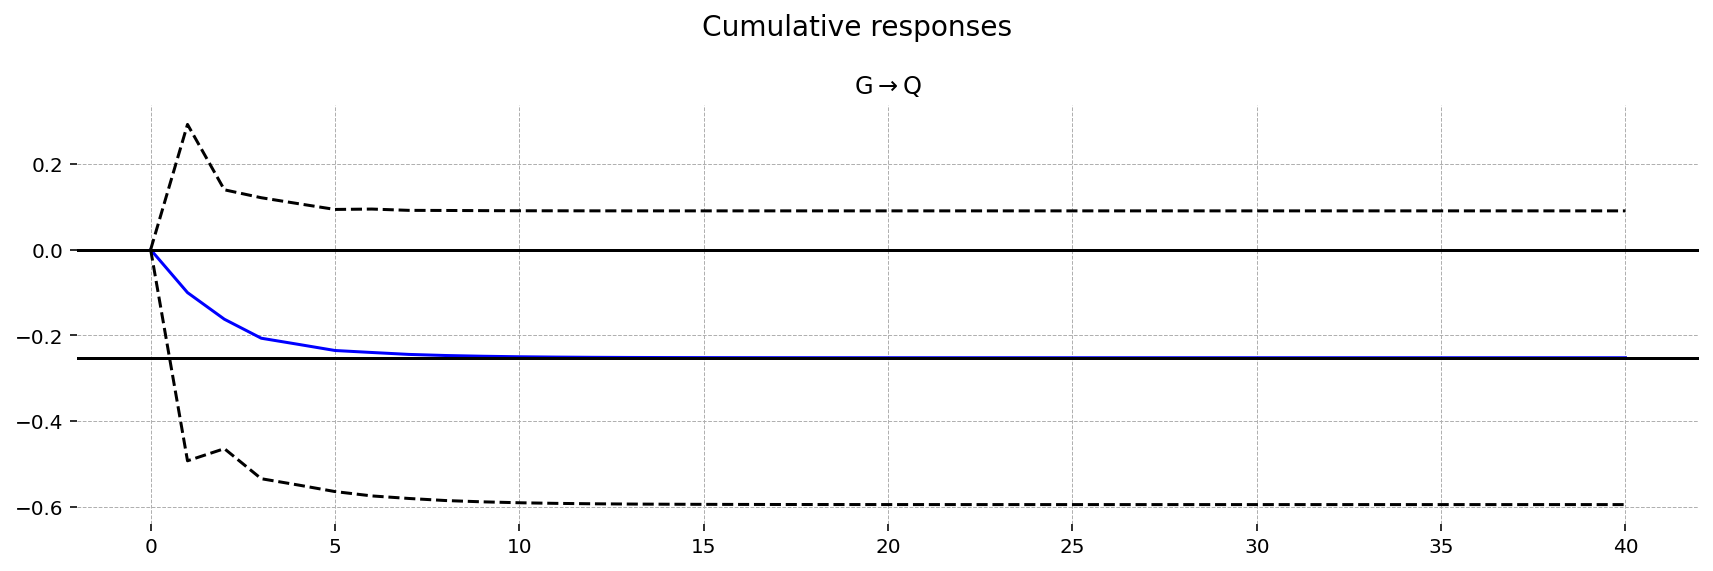

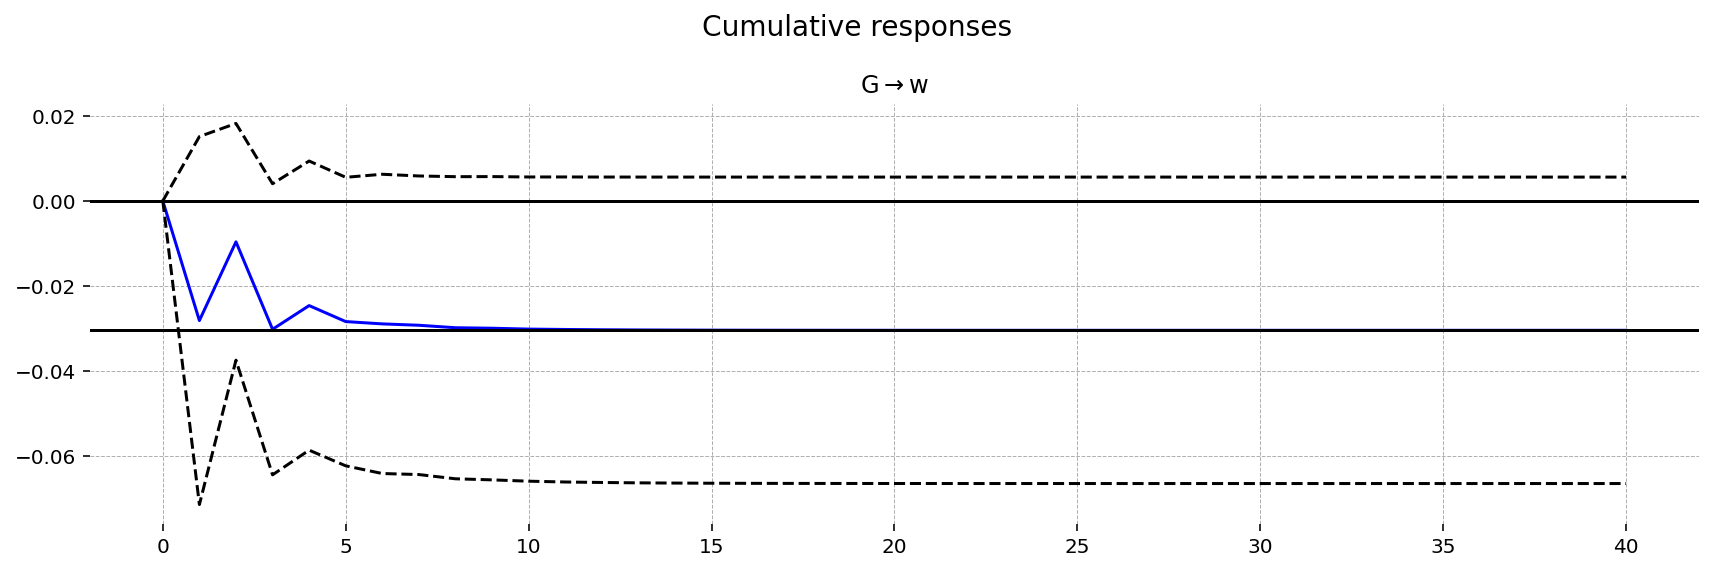

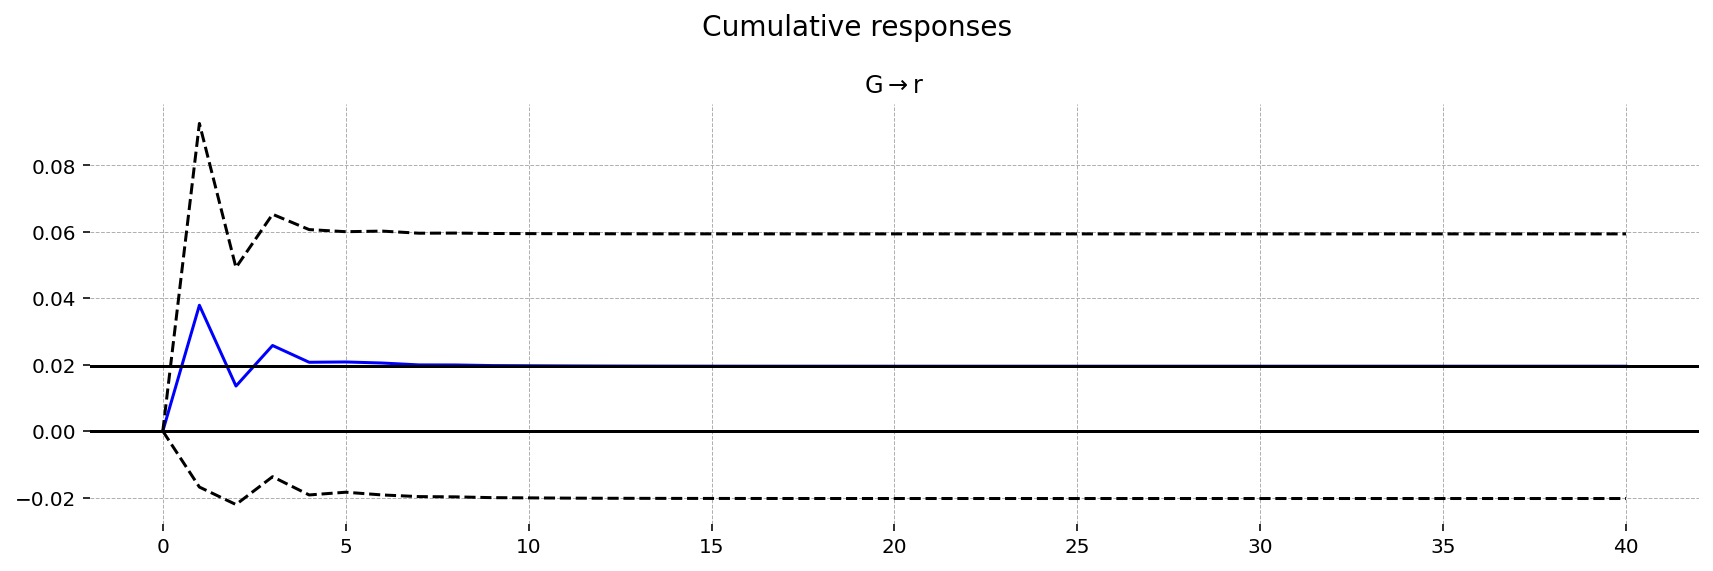

In [78]:
irf.plot_cum_effects(impulse='G', response='Y', figsize=(12, 4))
plt.tight_layout()
plt.savefig('GY.png')

irf.plot_cum_effects(impulse='G', response='pi', figsize=(12, 4))
plt.tight_layout()
plt.savefig('Gpi.png')

irf.plot_cum_effects(impulse='G', response='u', figsize=(12, 4))
plt.tight_layout()
plt.savefig('Gu.png')

irf.plot_cum_effects(impulse='G', response='Q', figsize=(12, 4))
plt.tight_layout()
plt.savefig('GQ.png')

irf.plot_cum_effects(impulse='G', response='w', figsize=(12, 4))
plt.tight_layout()
plt.savefig('Gw.png')

irf.plot_cum_effects(impulse='G', response='r', figsize=(12, 4))
plt.tight_layout()
plt.savefig('Gr.png')

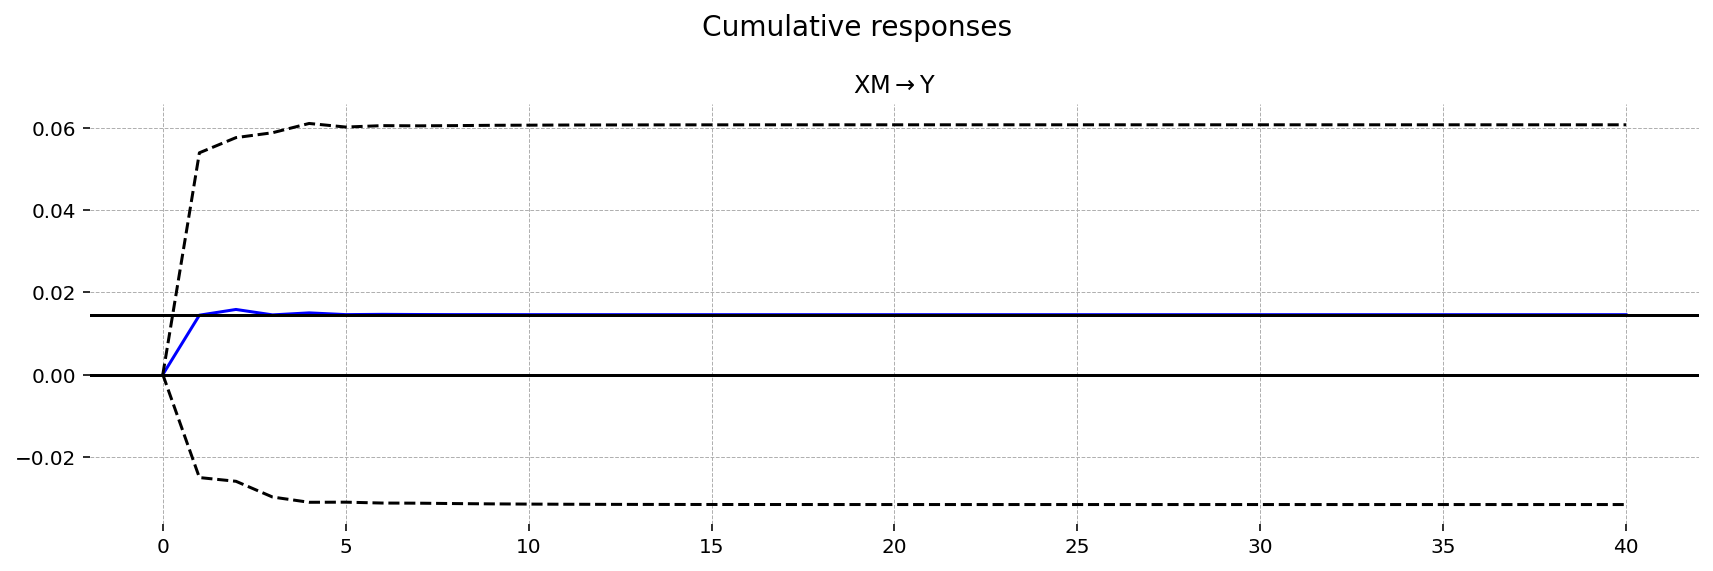

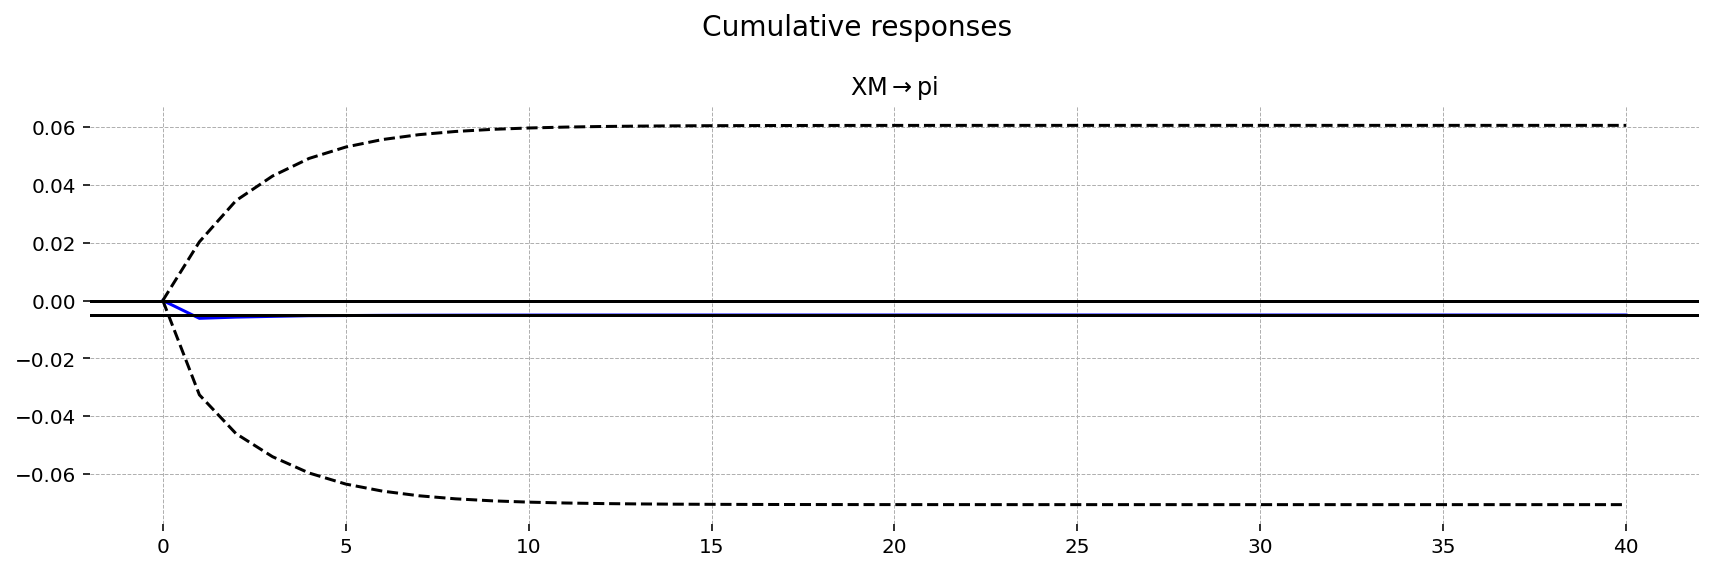

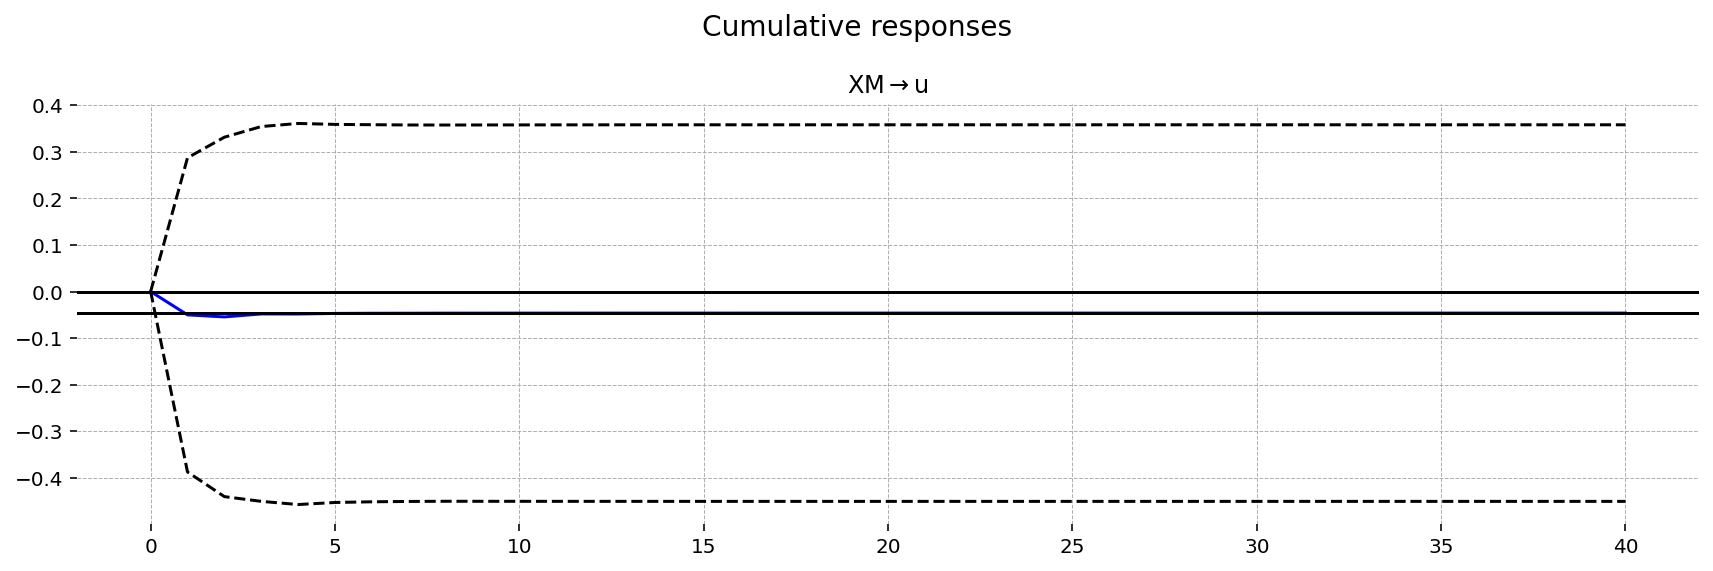

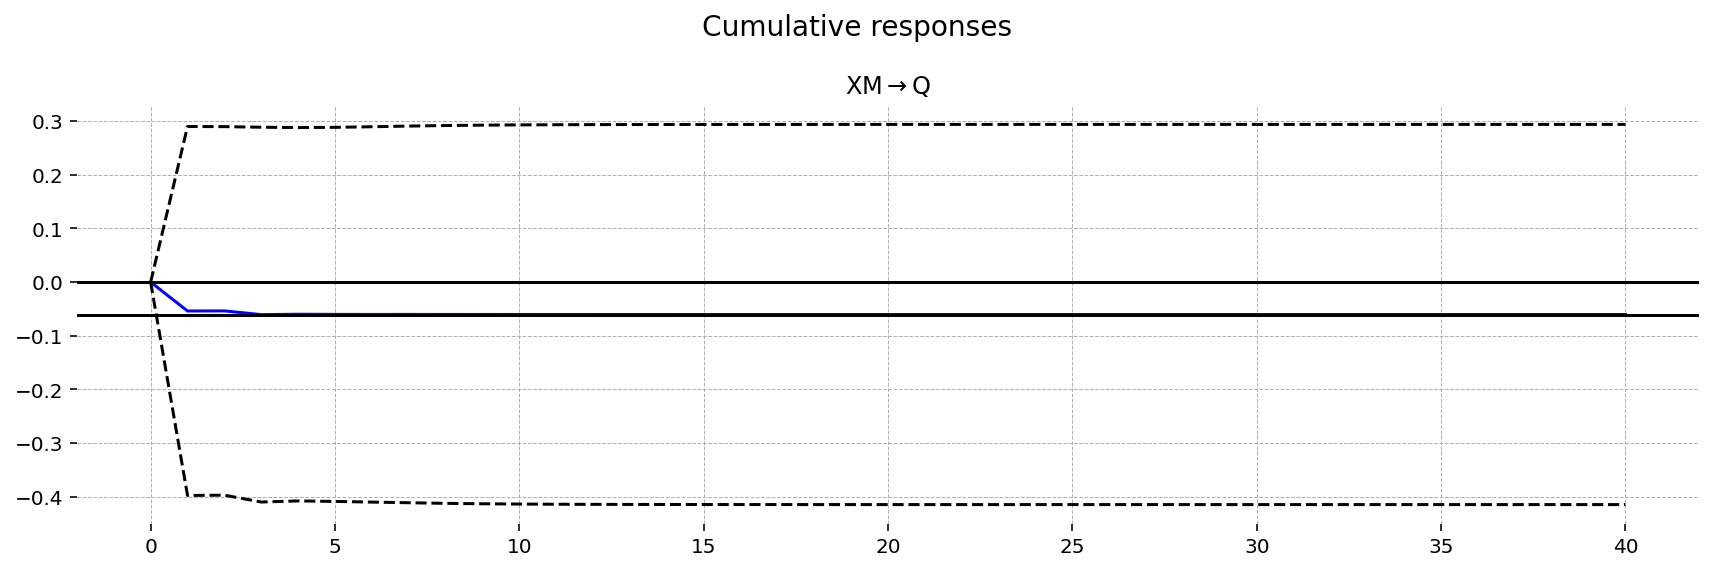

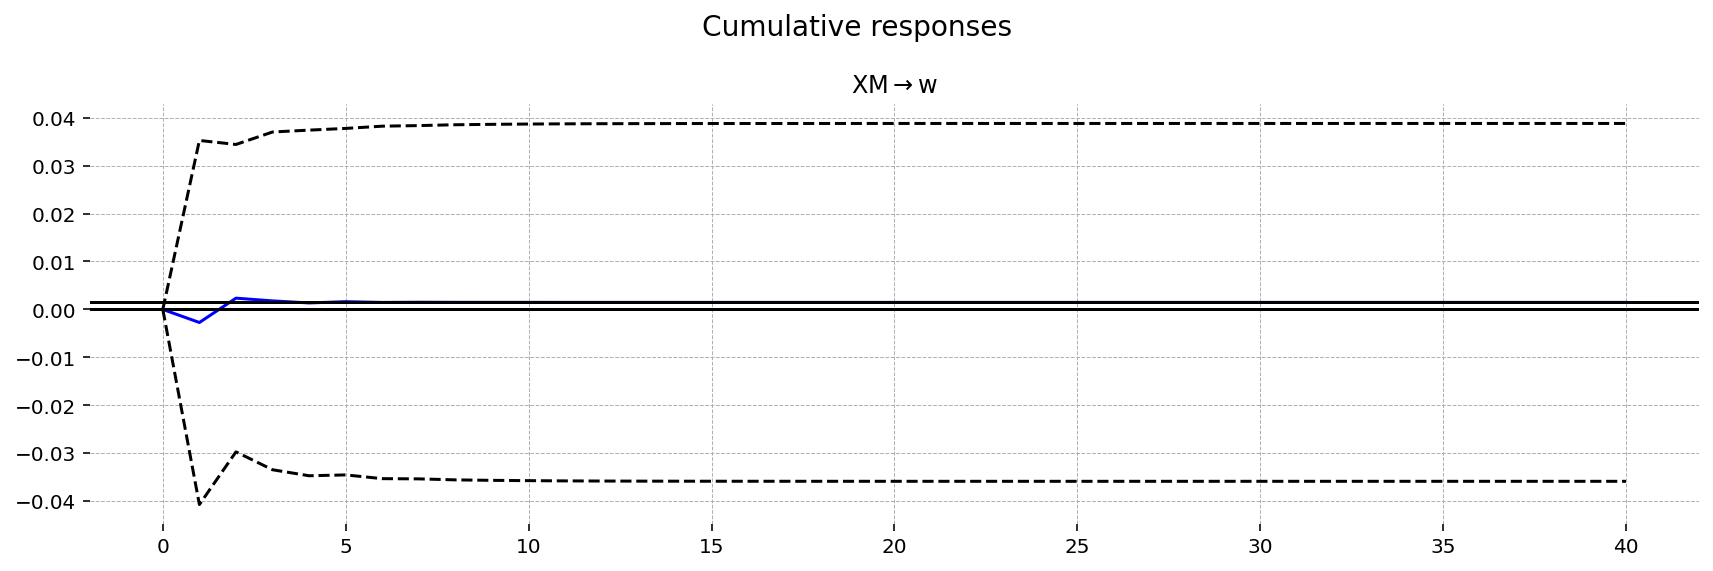

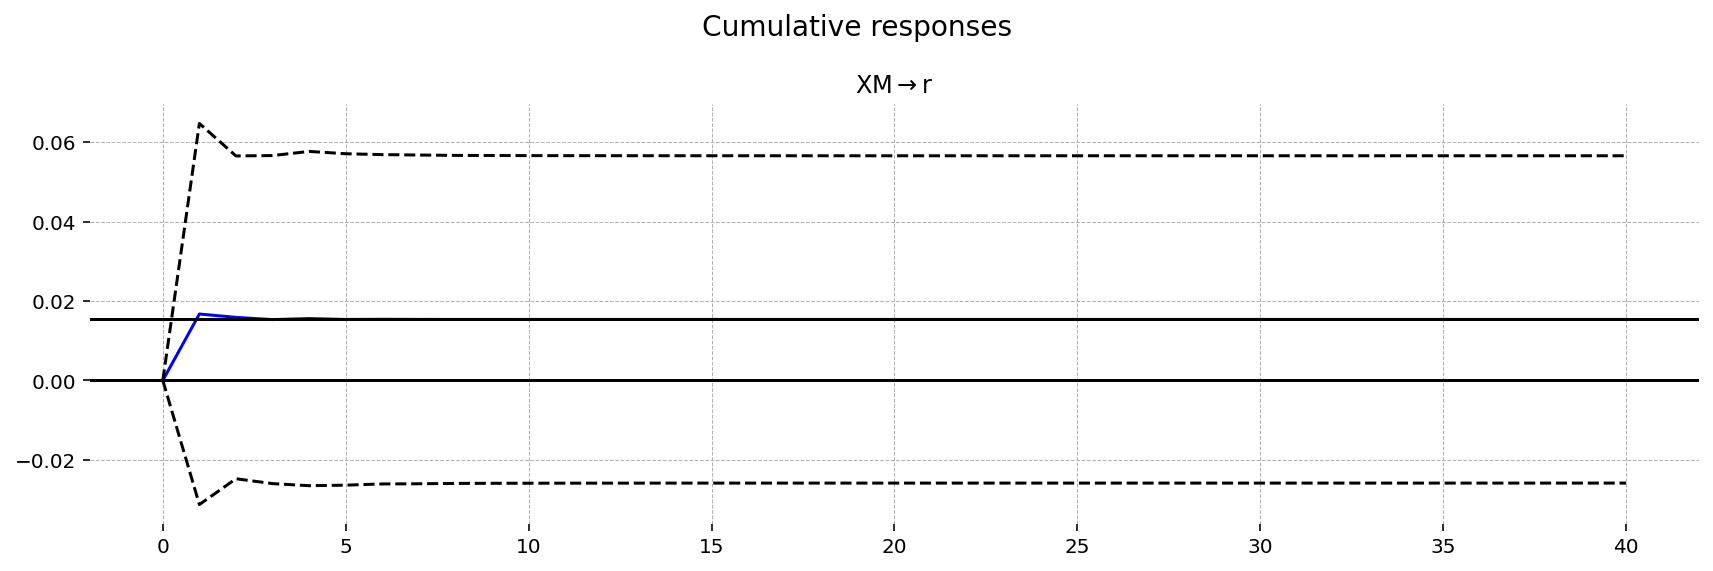

In [79]:
irf.plot_cum_effects(impulse='XM', response='Y', figsize=(12, 4))
plt.tight_layout()
plt.savefig('XMY.png')

irf.plot_cum_effects(impulse='XM', response='pi', figsize=(12, 4))
plt.tight_layout()
plt.savefig('XMpi.png')

irf.plot_cum_effects(impulse='XM', response='u', figsize=(12, 4))
plt.tight_layout()
plt.savefig('XMu.png')

irf.plot_cum_effects(impulse='XM', response='Q', figsize=(12, 4))
plt.tight_layout()
plt.savefig('XMQ.png')

irf.plot_cum_effects(impulse='XM', response='w', figsize=(12, 4))
plt.tight_layout()
plt.savefig('XMw.png')

irf.plot_cum_effects(impulse='XM', response='r', figsize=(12, 4))
plt.tight_layout()
plt.savefig('XMr.png')

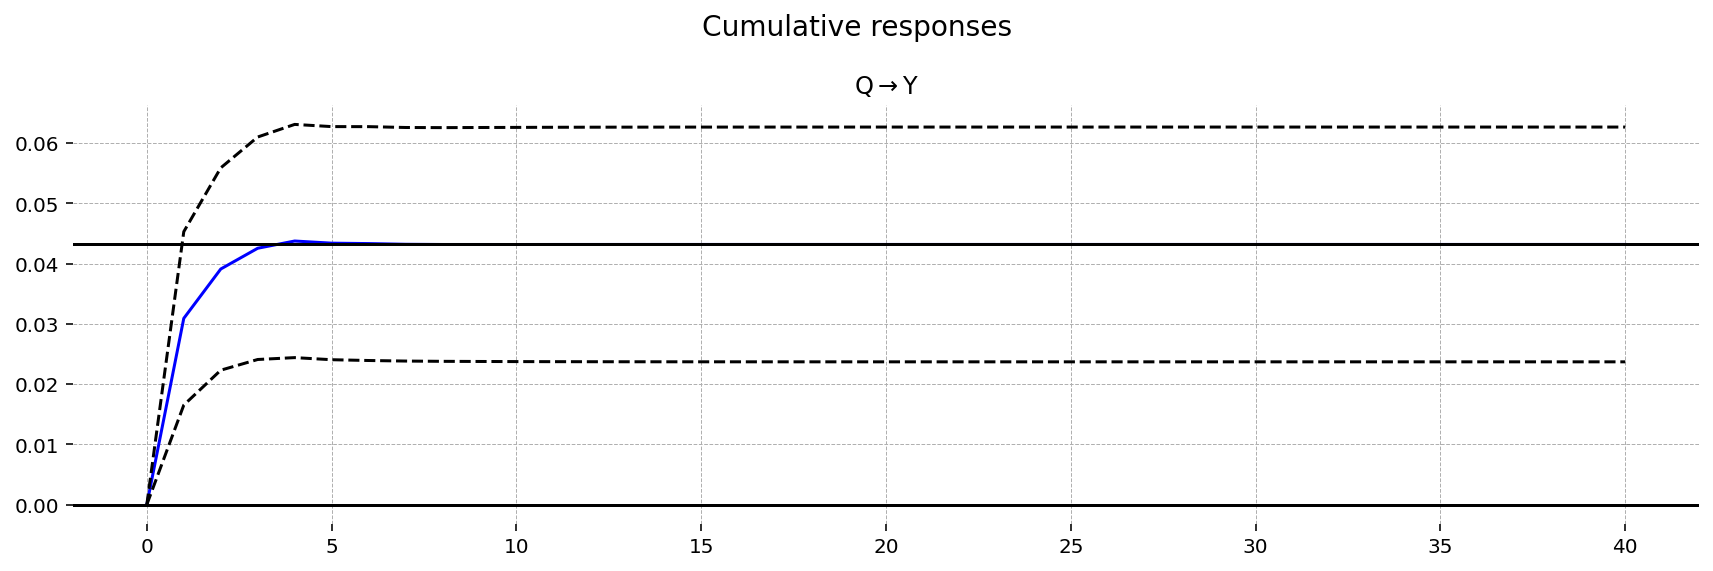

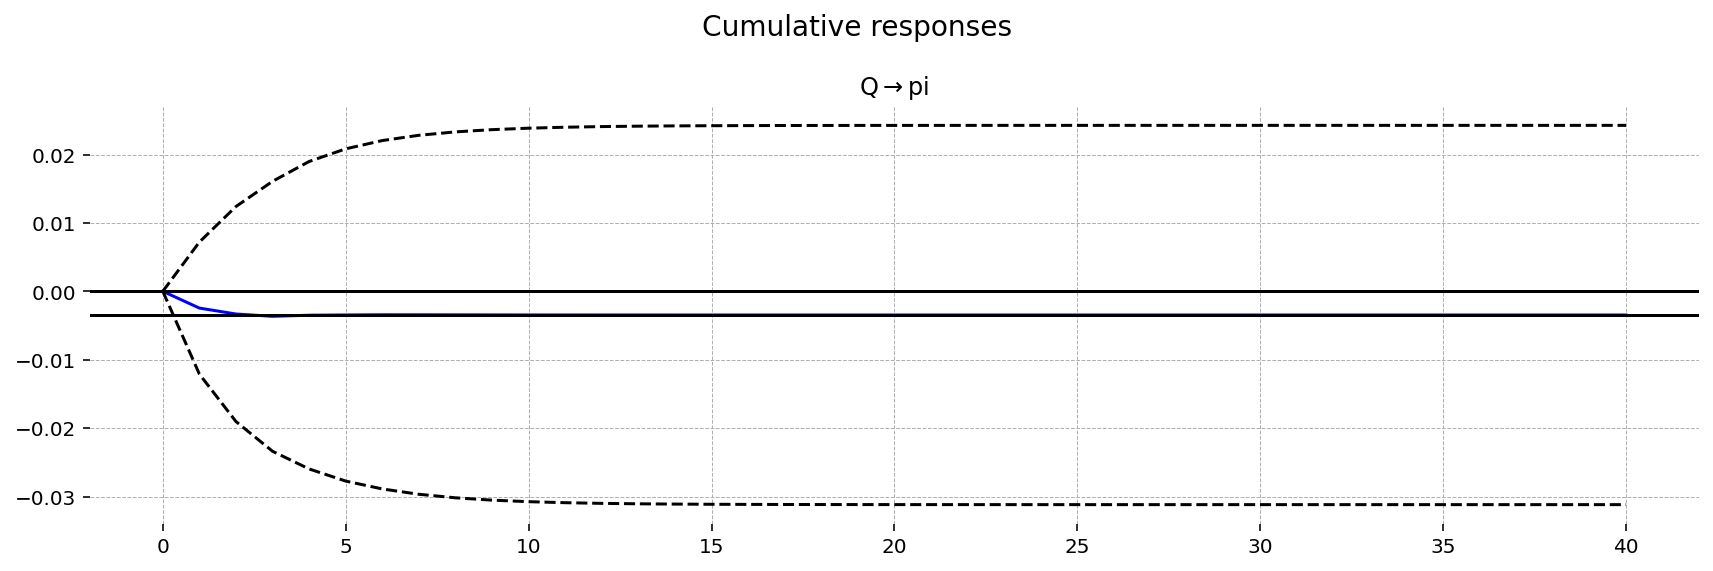

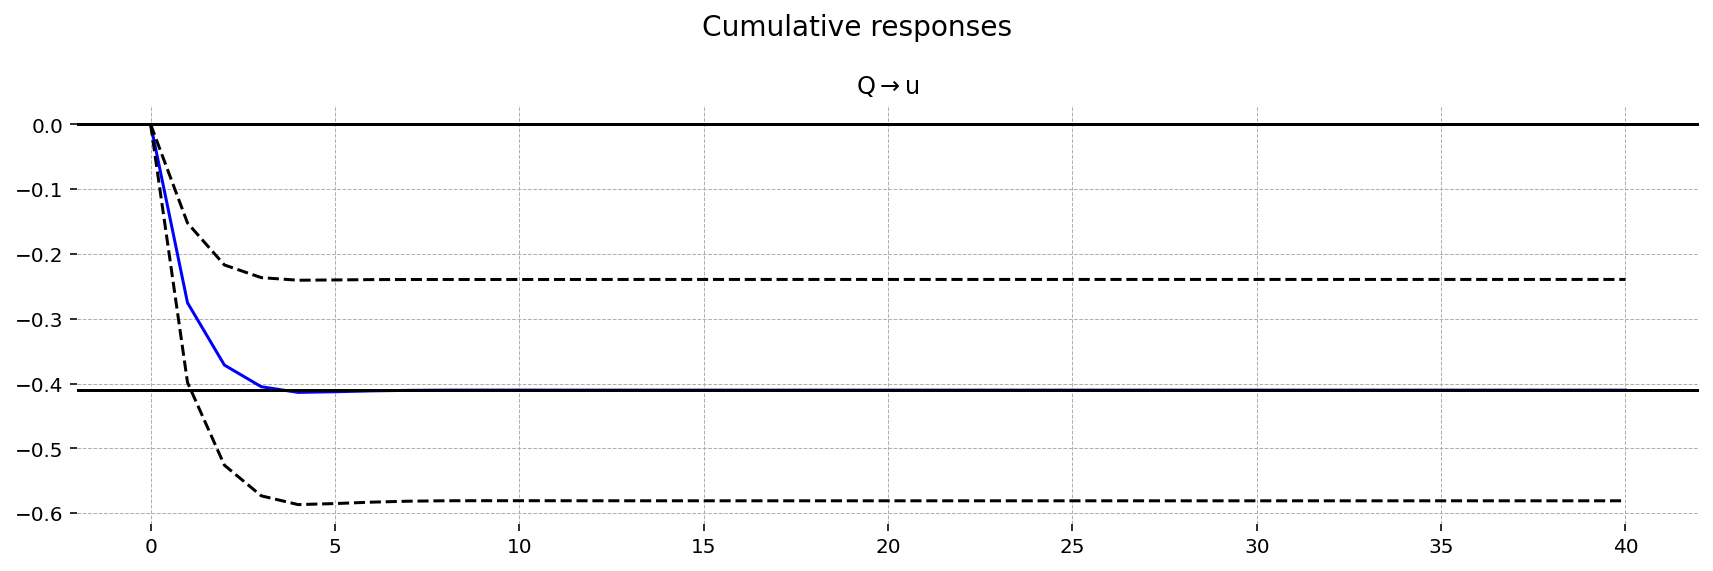

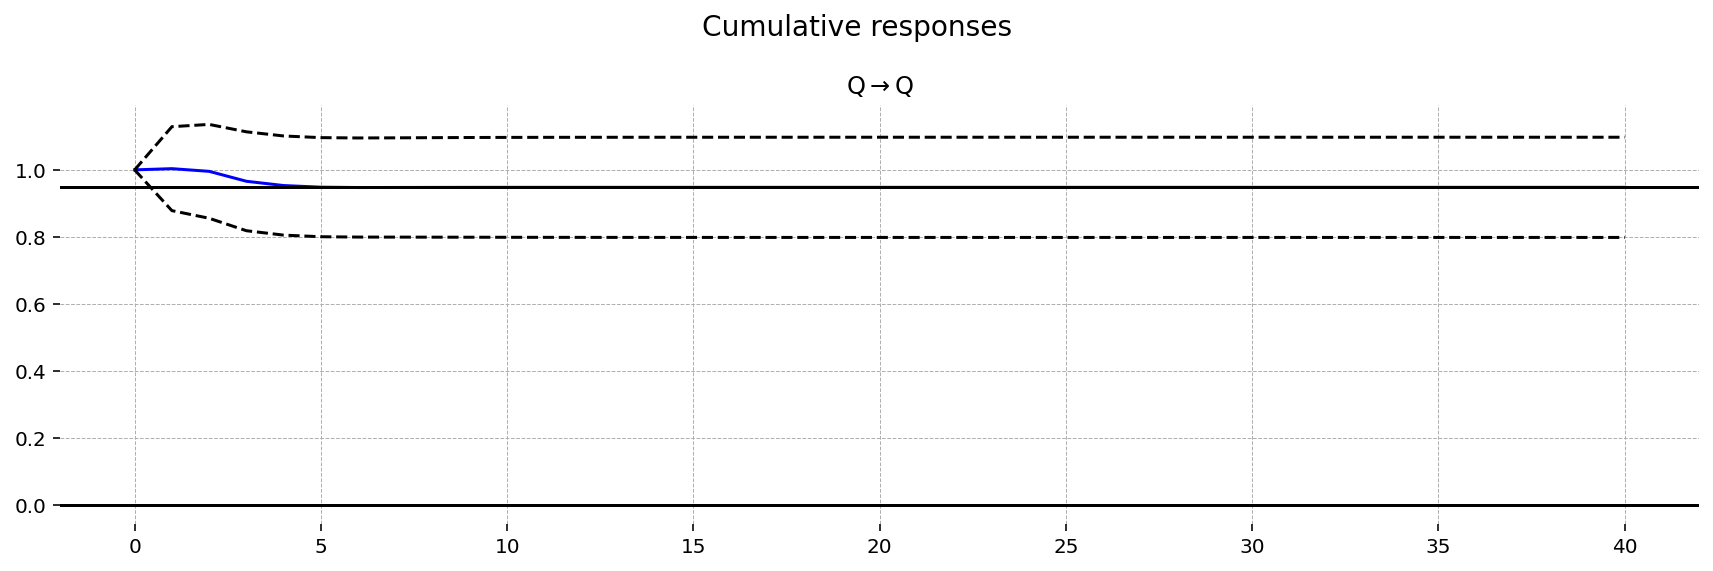

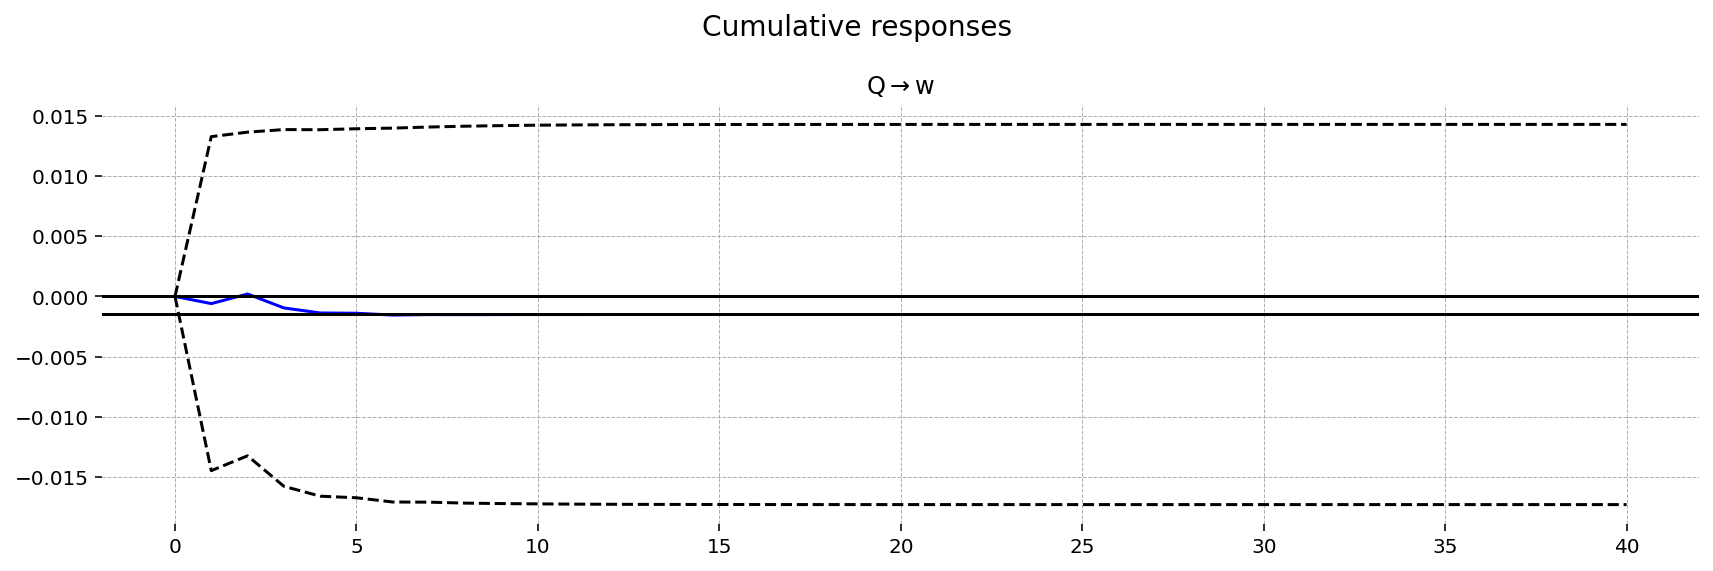

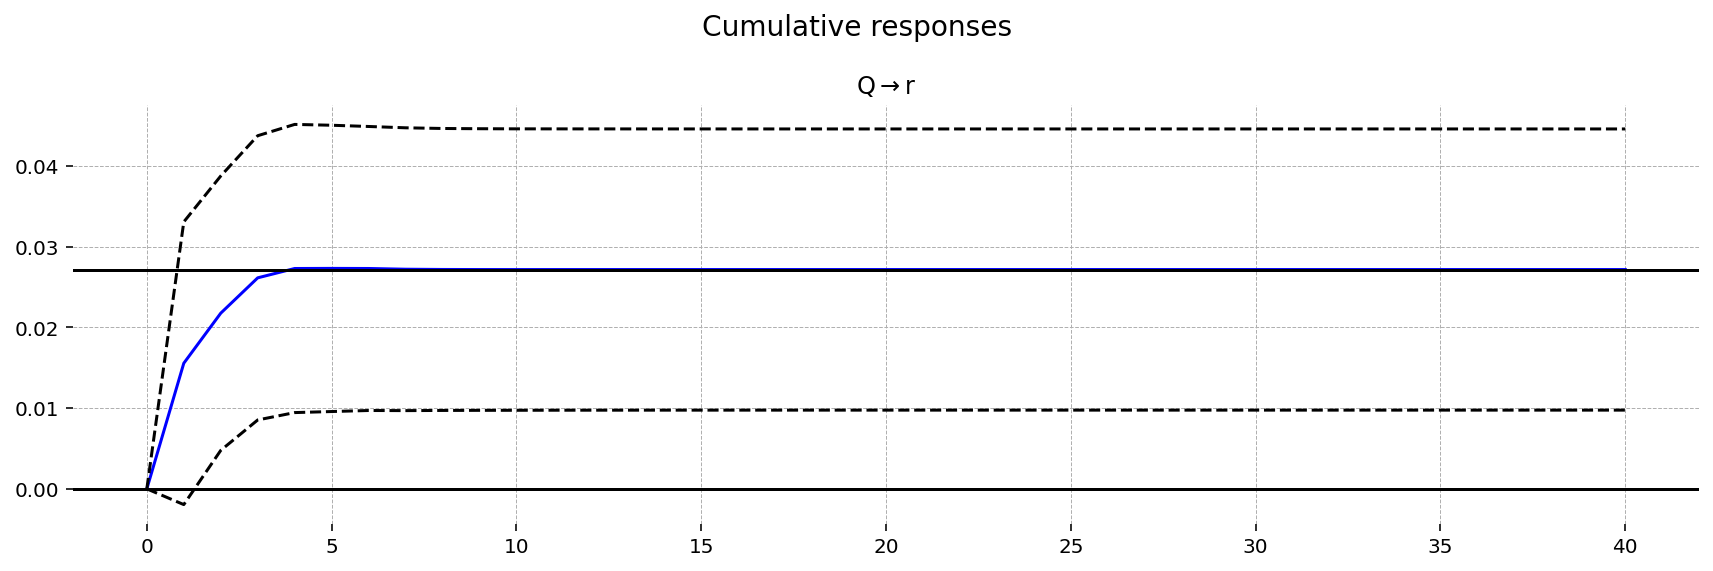

In [80]:
irf.plot_cum_effects(impulse='Q', response='Y', figsize=(12, 4))
plt.tight_layout()
plt.savefig('QY.png')

irf.plot_cum_effects(impulse='Q', response='pi', figsize=(12, 4))
plt.tight_layout()
plt.savefig('Qpi.png')

irf.plot_cum_effects(impulse='Q', response='u', figsize=(12, 4))
plt.tight_layout()
plt.savefig('Qu.png')

irf.plot_cum_effects(impulse='Q', response='Q', figsize=(12, 4))
plt.tight_layout()
plt.savefig('QQ.png')

irf.plot_cum_effects(impulse='Q', response='w', figsize=(12, 4))
plt.tight_layout()
plt.savefig('Qw.png')

irf.plot_cum_effects(impulse='Q', response='r', figsize=(12, 4))
plt.tight_layout()
plt.savefig('Qr.png')

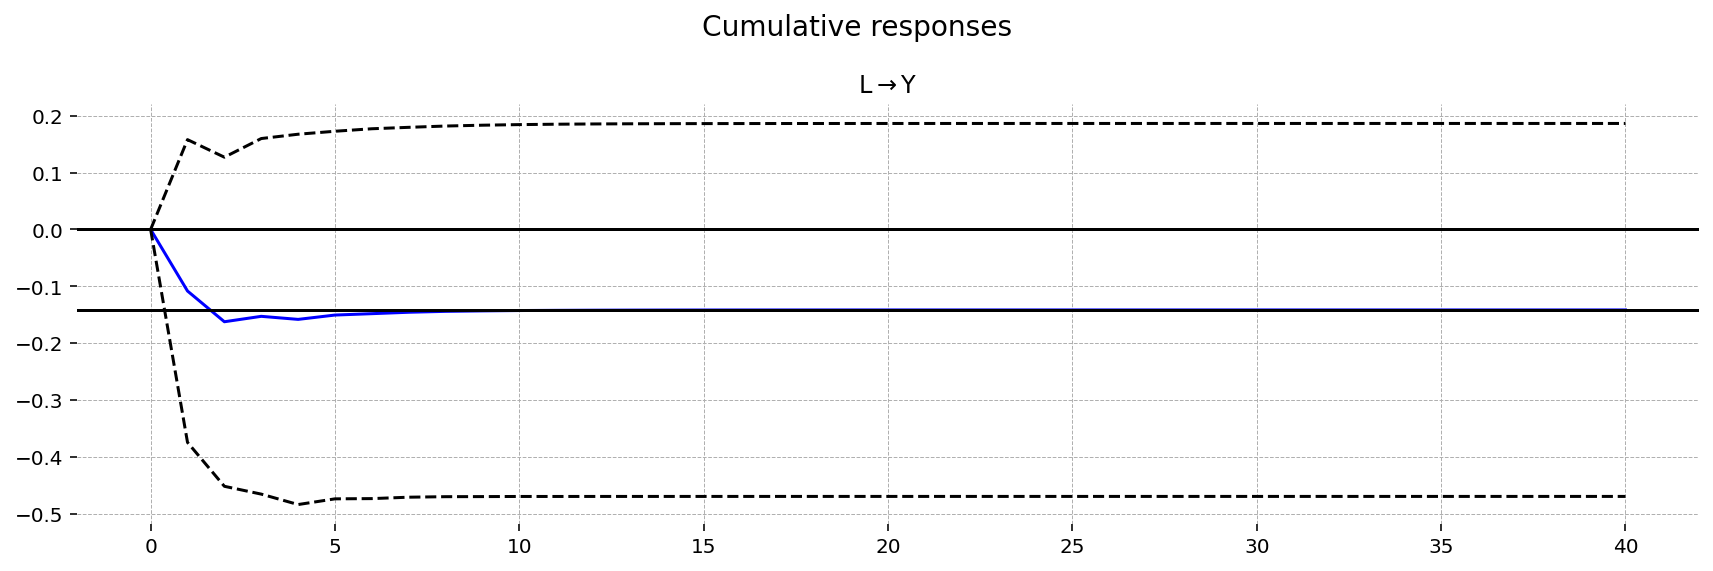

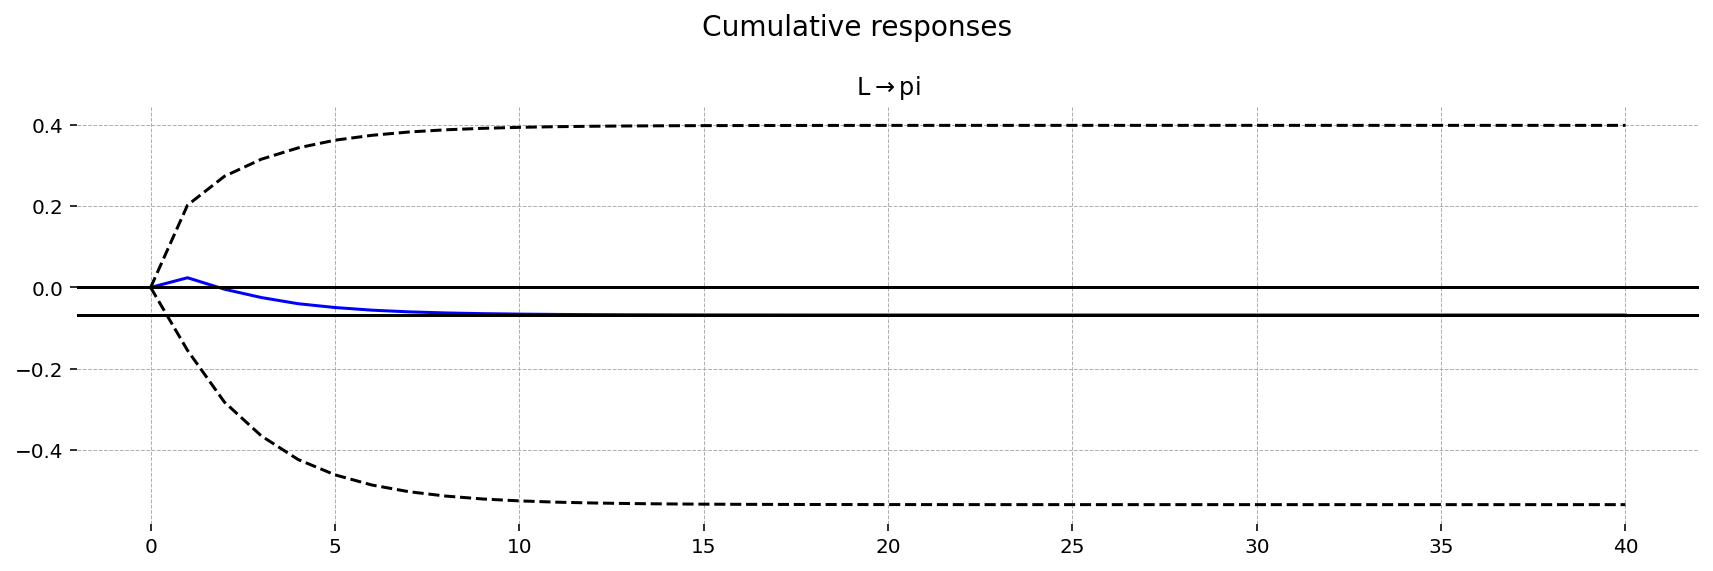

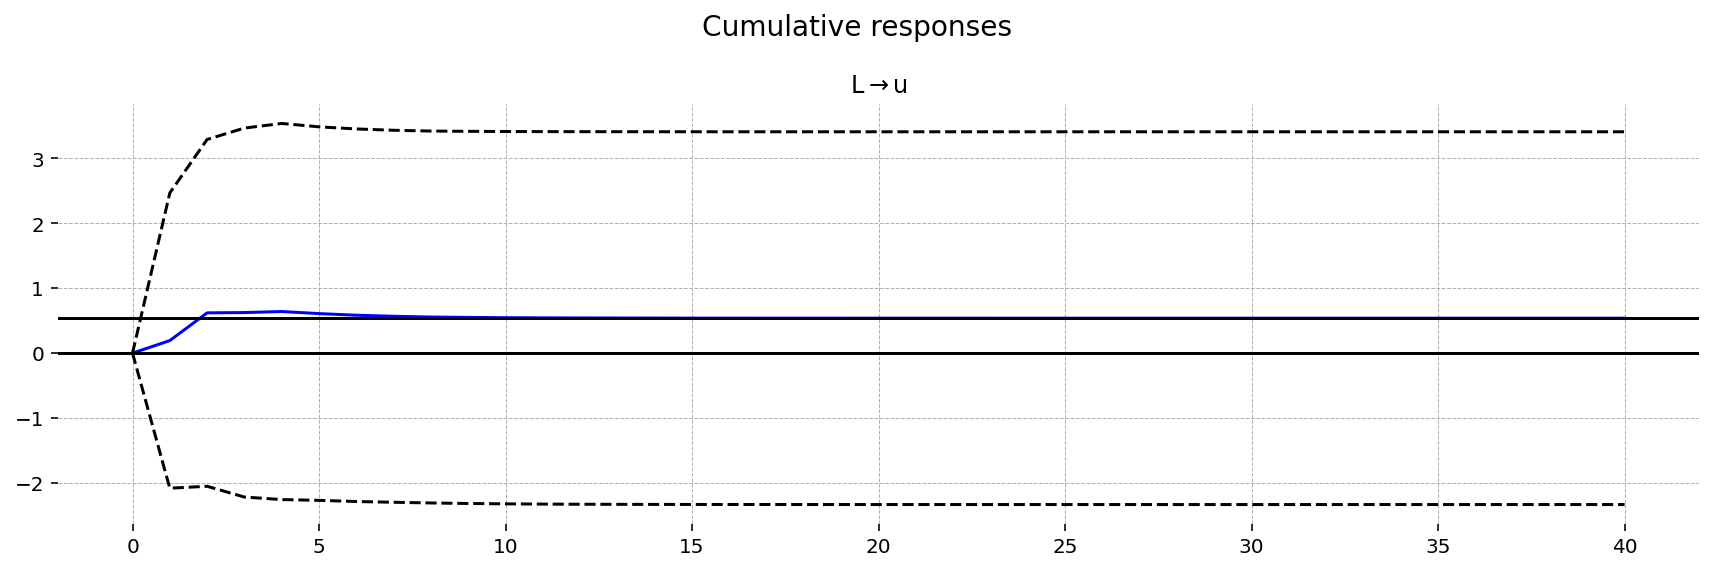

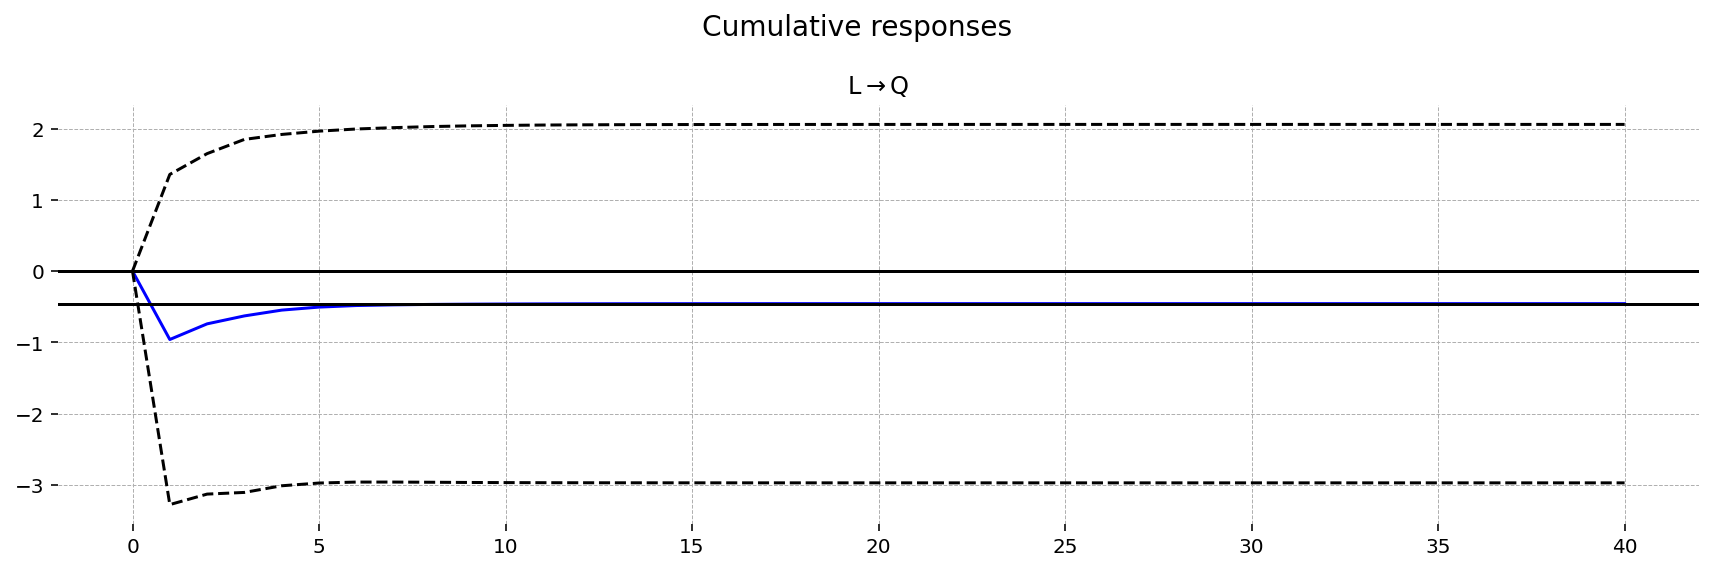

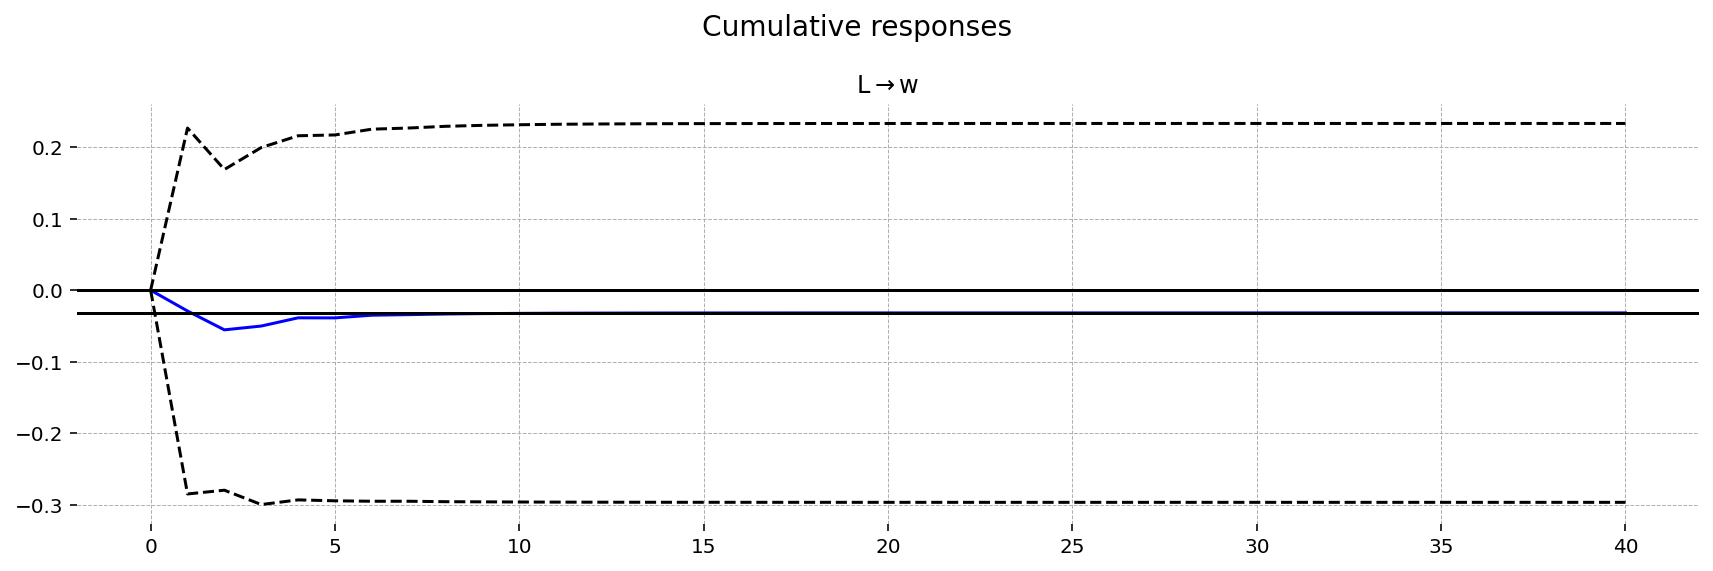

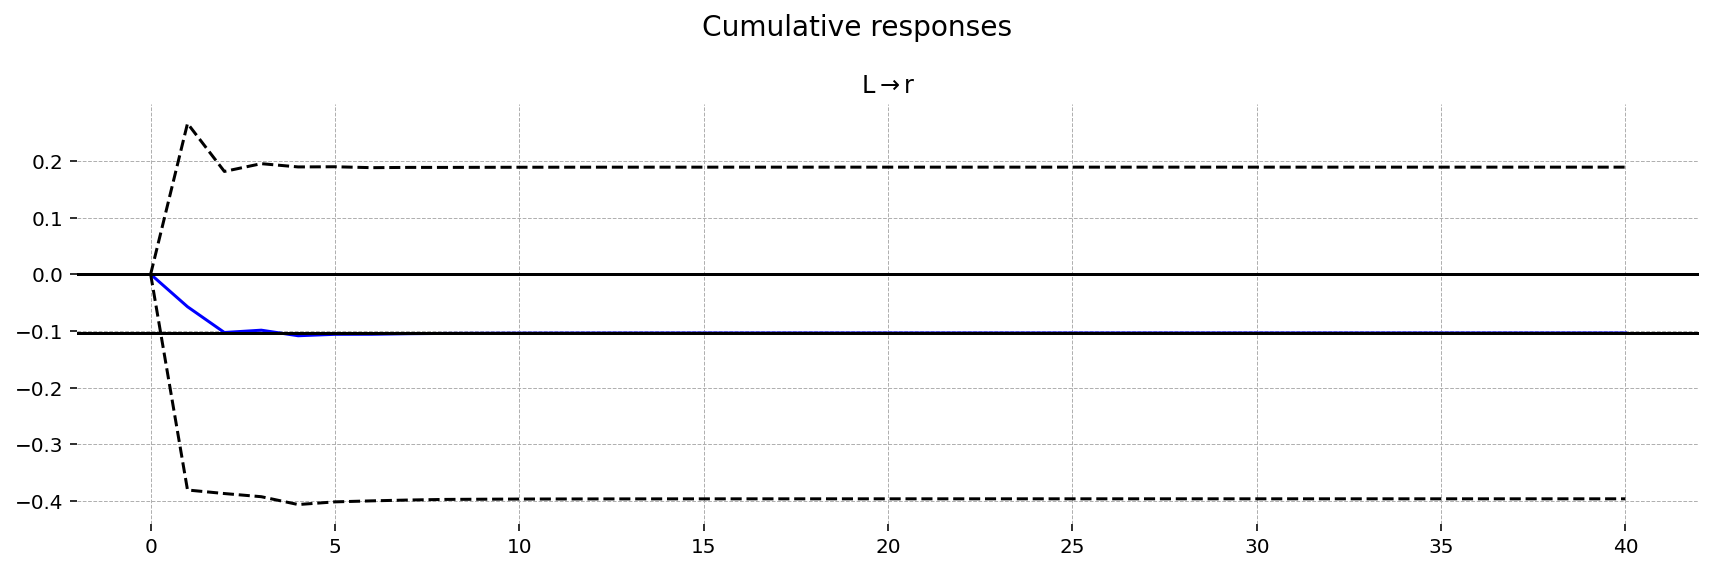

In [81]:
irf.plot_cum_effects(impulse='L', response='Y', figsize=(12, 4))
plt.tight_layout()
plt.savefig('LY.png')

irf.plot_cum_effects(impulse='L', response='pi', figsize=(12, 4))
plt.tight_layout()
plt.savefig('Lpi.png')

irf.plot_cum_effects(impulse='L', response='u', figsize=(12, 4))
plt.tight_layout()
plt.savefig('Lu.png')

irf.plot_cum_effects(impulse='L', response='Q', figsize=(12, 4))
plt.tight_layout()
plt.savefig('LQ.png')

irf.plot_cum_effects(impulse='L', response='w', figsize=(12, 4))
plt.tight_layout()
plt.savefig('Lw.png')

irf.plot_cum_effects(impulse='L', response='r', figsize=(12, 4))
plt.tight_layout()
plt.savefig('Lr.png')

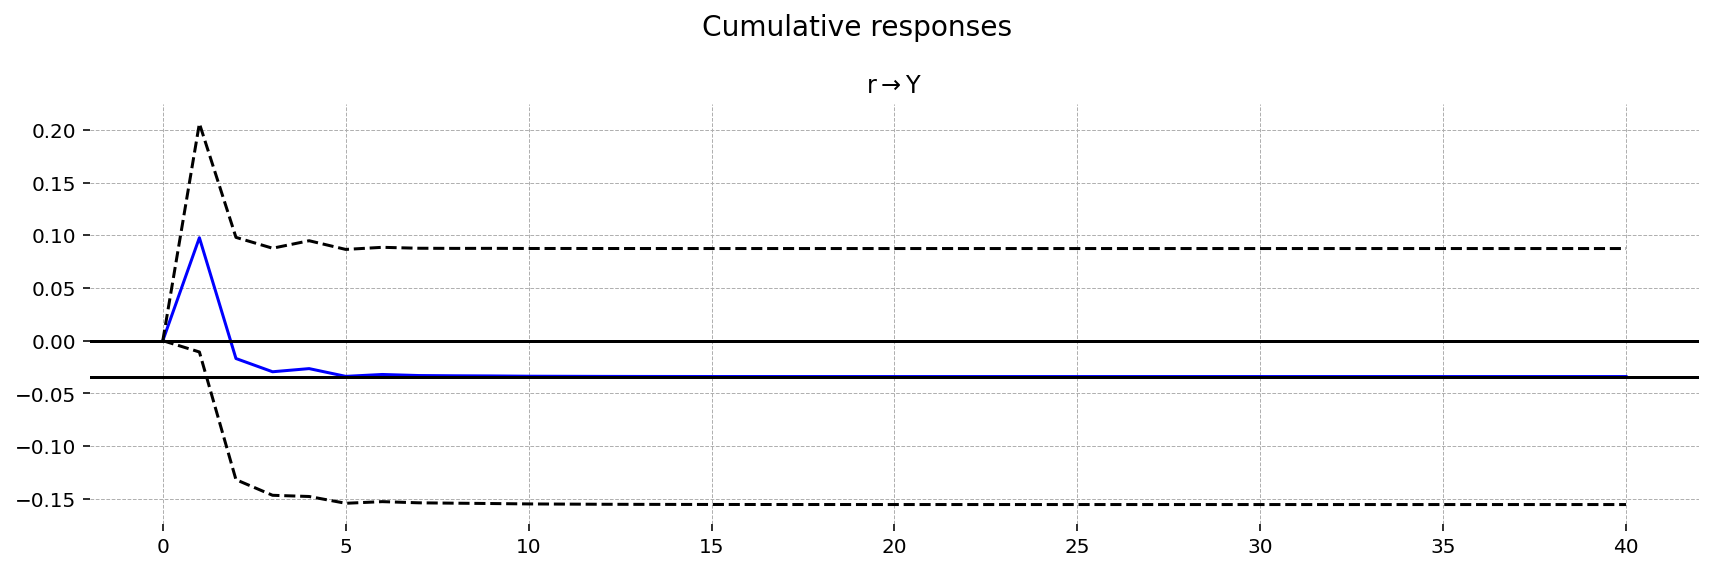

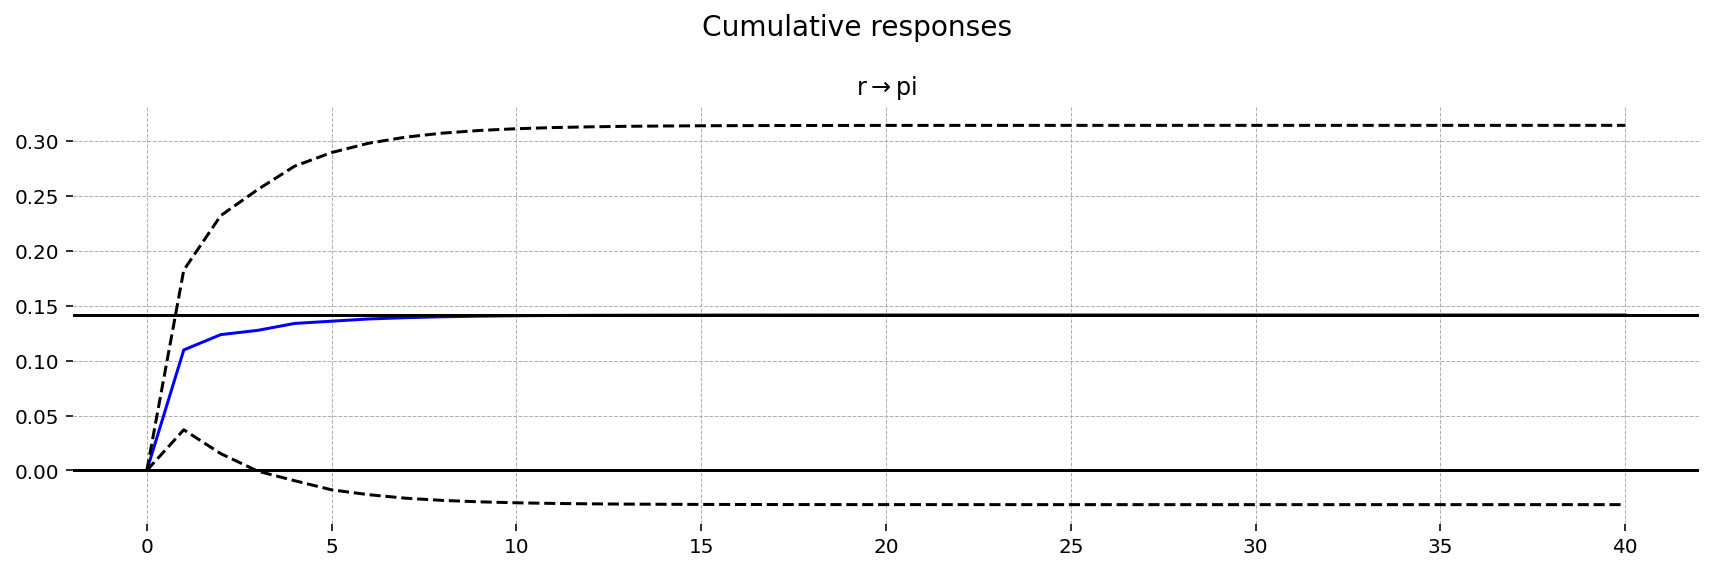

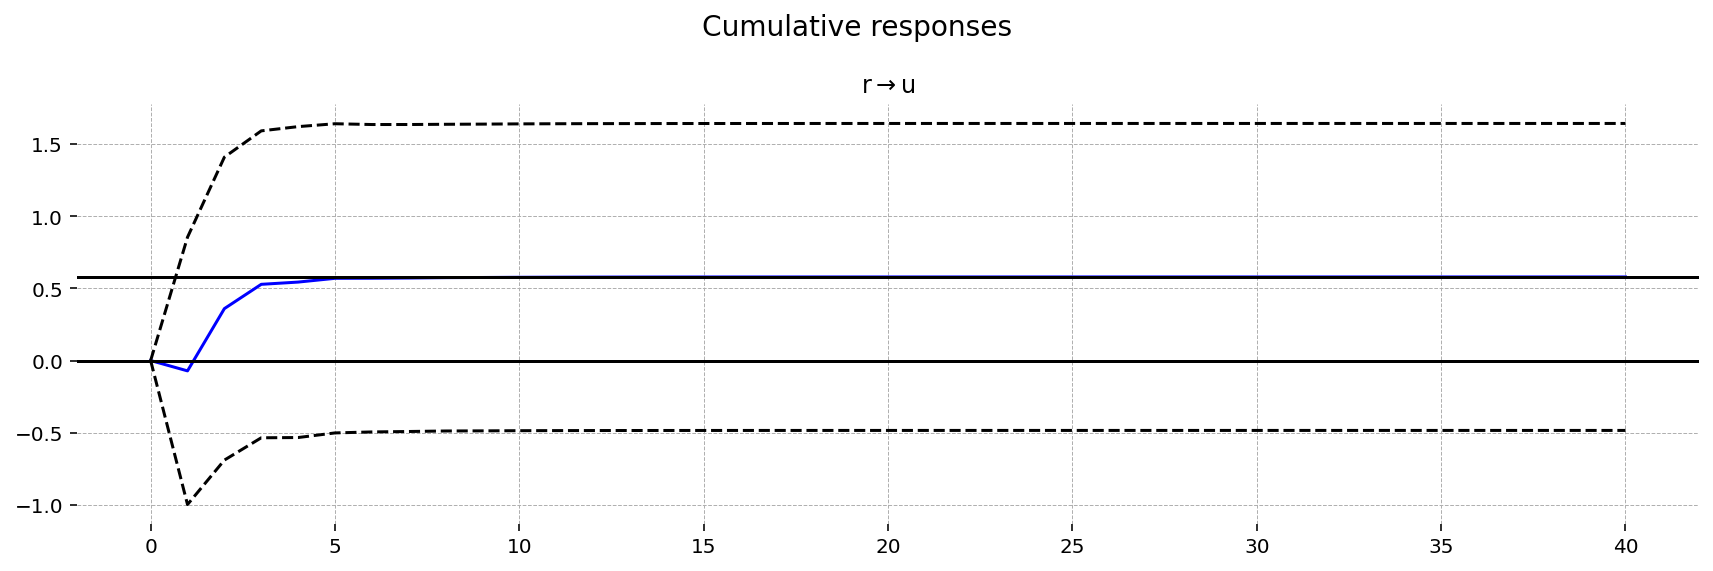

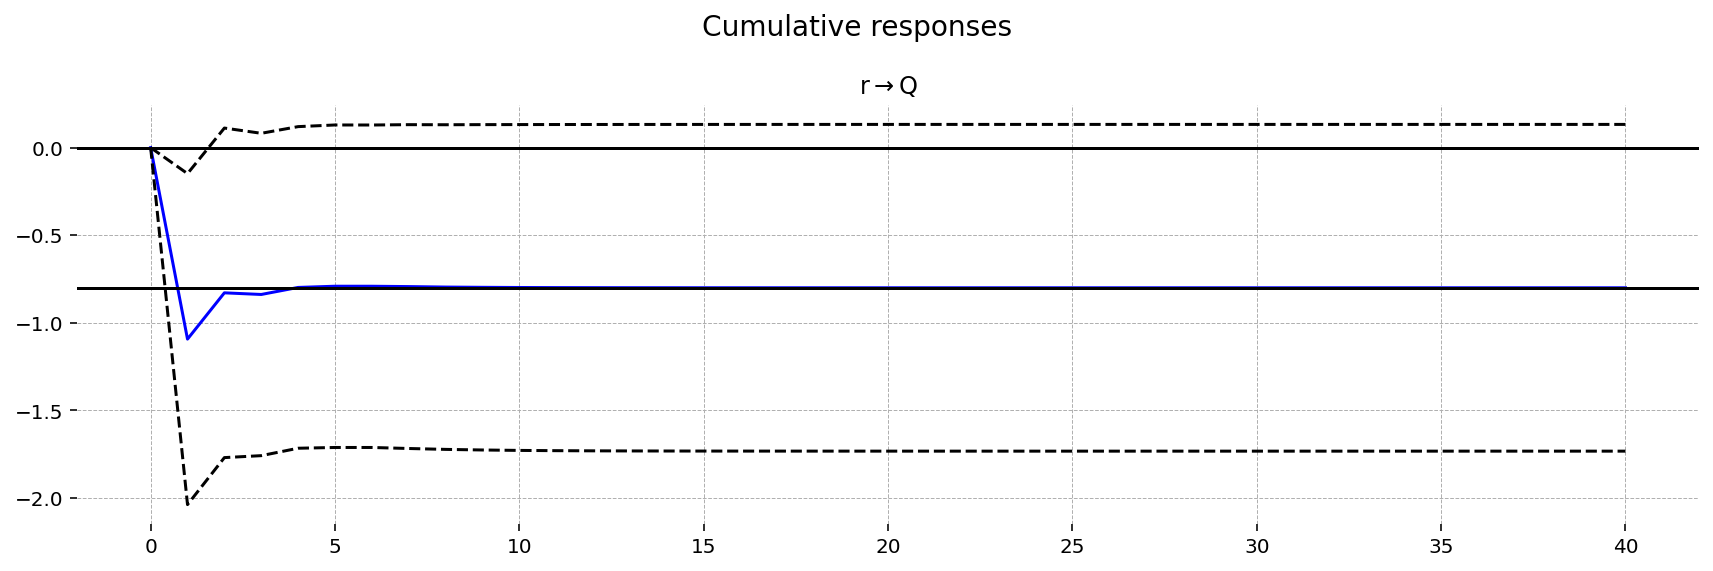

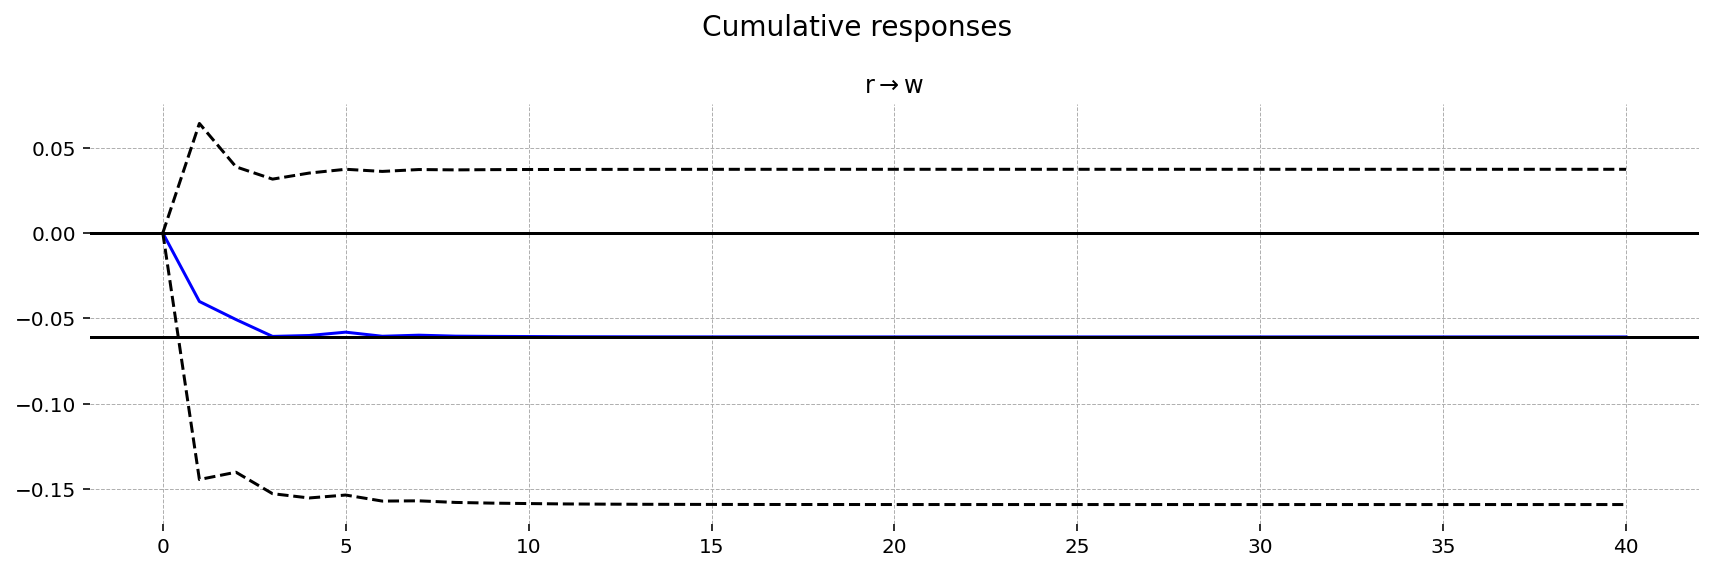

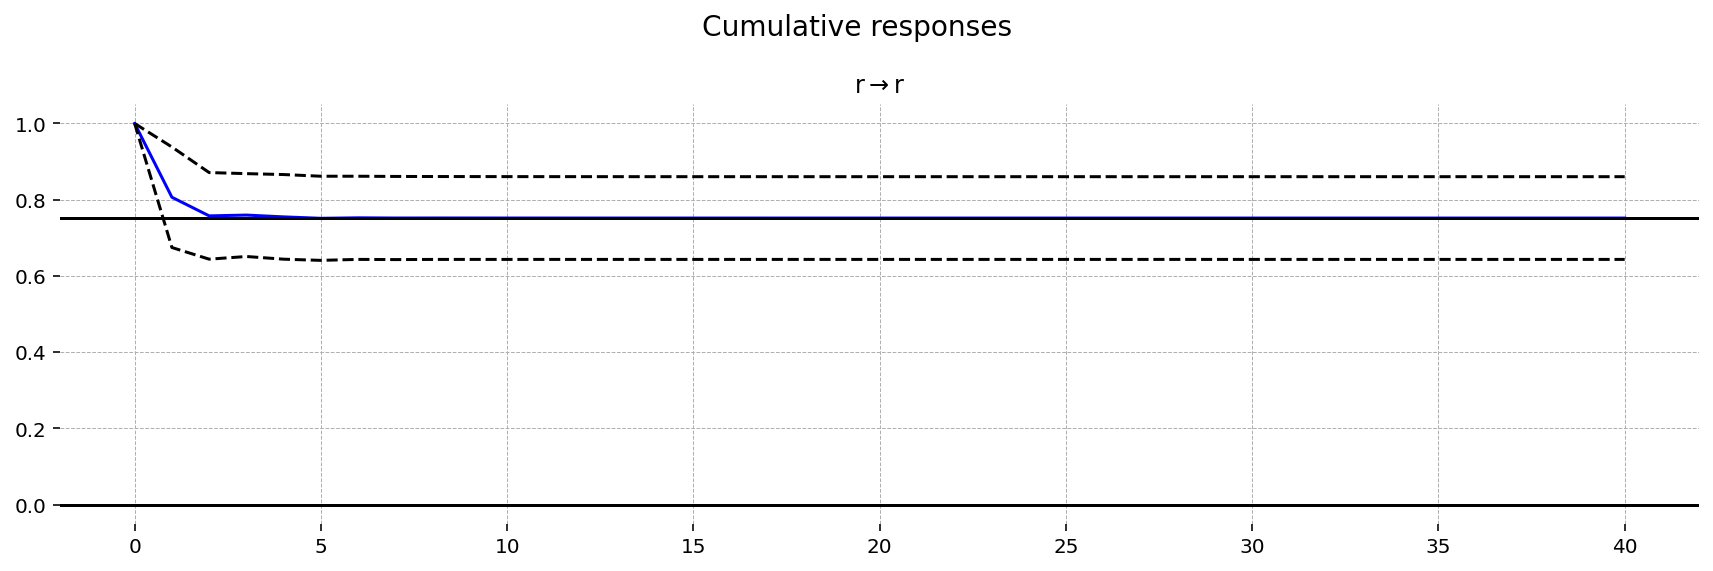

In [82]:
irf.plot_cum_effects(impulse='r', response='Y', figsize=(12, 4))
plt.tight_layout()
plt.savefig('rY.png')

irf.plot_cum_effects(impulse='r', response='pi', figsize=(12, 4))
plt.tight_layout()
plt.savefig('rpi.png')

irf.plot_cum_effects(impulse='r', response='u', figsize=(12, 4))
plt.tight_layout()
plt.savefig('ru.png')

irf.plot_cum_effects(impulse='r', response='Q', figsize=(12, 4))
plt.tight_layout()
plt.savefig('rQ.png')

irf.plot_cum_effects(impulse='r', response='w', figsize=(12, 4))
plt.tight_layout()
plt.savefig('rw.png')

irf.plot_cum_effects(impulse='r', response='r', figsize=(12, 4))
plt.tight_layout()
plt.savefig('rr.png')